# Index   

0. [Importing libraries](##0.-Importing-libraries) 

1. [Exploratory Data Analysis](#1.-Exploratory-Data-Analysis)

2. [Data Enginnering](#2.-Data-Engineering)
 
3. [Data engineering study with Pycaret](#-3.-Data-engineering-study-with-Pycaret)

4. [Tunning Random Forest Hyperparameters](#-4.-Random-Forest-Hyperparameters-tunning)

5. [Prediction of test_X](#-5.-test_X-prediction)

6. [Results and Conclusions](#-6.-Results-and-Conclusions)



### 0. Importing libraries

In [53]:
#Data exploration & manipulation
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.style as style 
import datetime as dt
import os
import matplotlib.pyplot as plt
import sweetviz as sv


print('sweetviz: %s' % sv.__version__) # print version

#ML Models search and optimisation
from pycaret.classification import * 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import optuna
print('optuna: %s' % optuna.__version__) # print version
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, RepeatedKFold, GridSearchCV


%matplotlib inline



# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version




# Sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sklearn # for model evaluation
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.preprocessing import OrdinalEncoder # for encoding labels
from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import StratifiedShuffleSplit # to split stratified 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, roc_auc_score, confusion_matrix
from sklearn.decomposition import PCA

# Visualization
import matplotlib.image as mpimg
import plotly.io as pio #To fix an issue with the renderer of graphs in VSC
pio.renderers
import matplotlib 
import matplotlib.pyplot as plt # for showing images
print('matplotlib: %s' % matplotlib.__version__) # print version
import random
import seaborn as sns
sns.set_style('white') 


# Other utilities
import sys
import os
from platform import python_version
import datetime
from time import localtime, strftime, gmtime
import pathlib
from glob import glob
from tqdm import tqdm


print('python version: %s' % python_version()) # print version

sweetviz: 2.1.4
optuna: 2.10.0
pandas: 1.3.5
numpy: 1.19.5
sklearn: 0.23.2
matplotlib: 3.5.1
python version: 3.7.12


# 1. Exploratory Data Analysis


In [2]:
# Import initial files from the website

volcano_train = pd.read_csv("https://challenges-asset-files.s3.us-east-2.amazonaws.com/data_sets/Data-Science/4+-+events/jobmadrid/dataset/jm_train.csv")

volcano_test = pd.read_csv("https://challenges-asset-files.s3.us-east-2.amazonaws.com/data_sets/Data-Science/4+-+events/jobmadrid/dataset/jm_X_test.csv")

predicitons_example = pd.read_csv("https://challenges-asset-files.s3.us-east-2.amazonaws.com/data_sets/Data-Science/4+-+events/jump2digital/dataset/ejemplo_predicciones.csv")


Let's do a fast exploration of train and test dataset with the library sweetviz.

In [3]:
feature_config = sv.FeatureConfig(force_num=["target"])

In [4]:
#analyzing the training dataset

volcano_train_report = sv.analyze(volcano_train, target_feat = 'target', feat_cfg=feature_config) 


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)



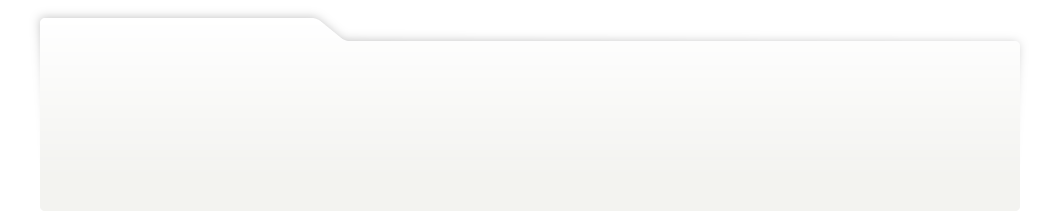
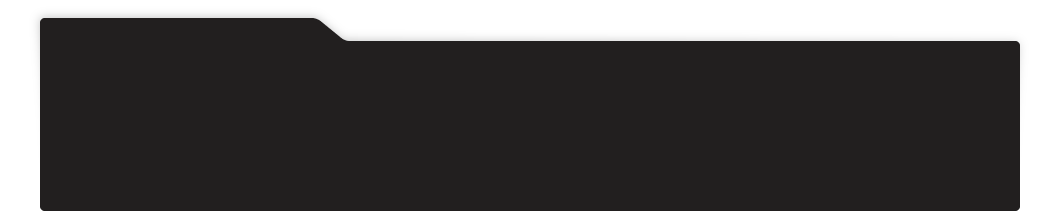
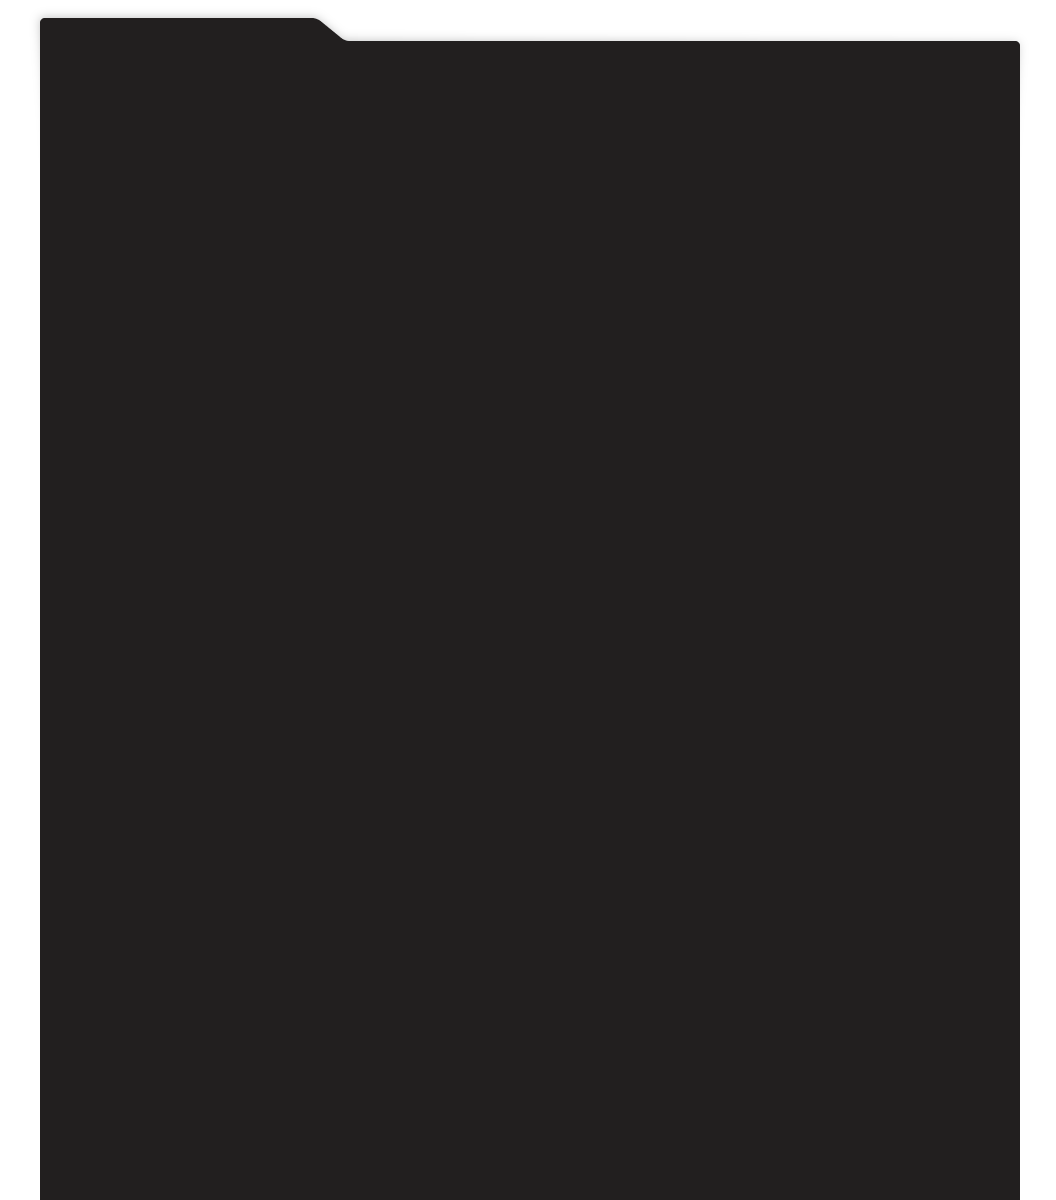
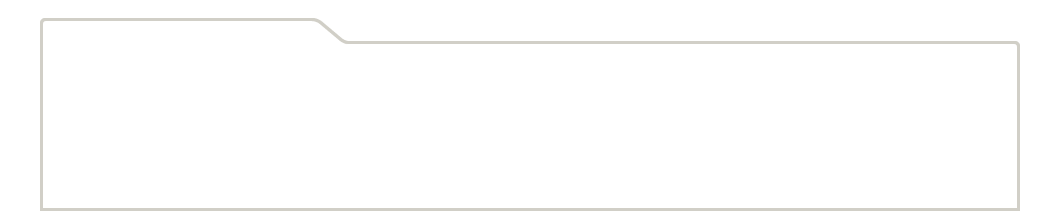
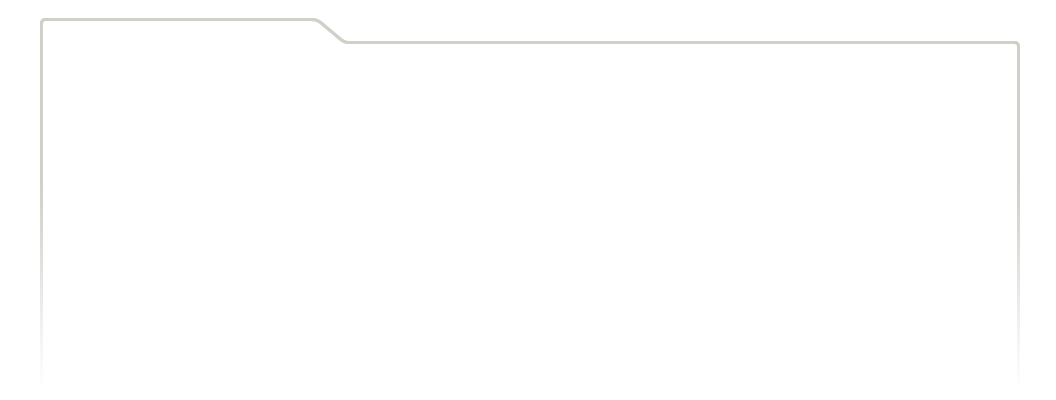
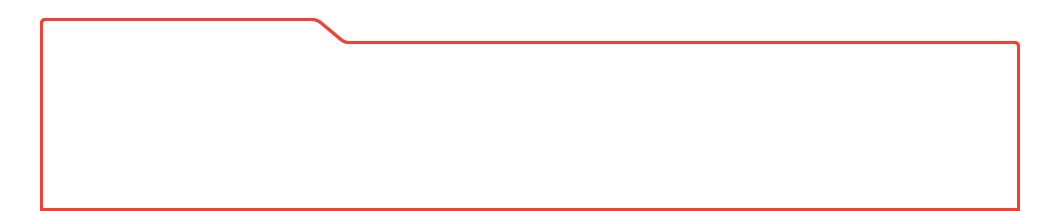
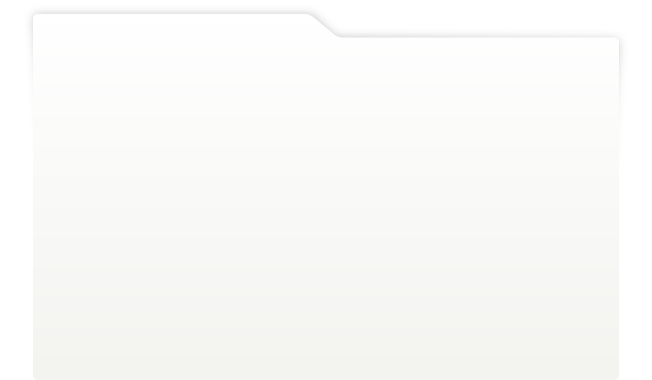
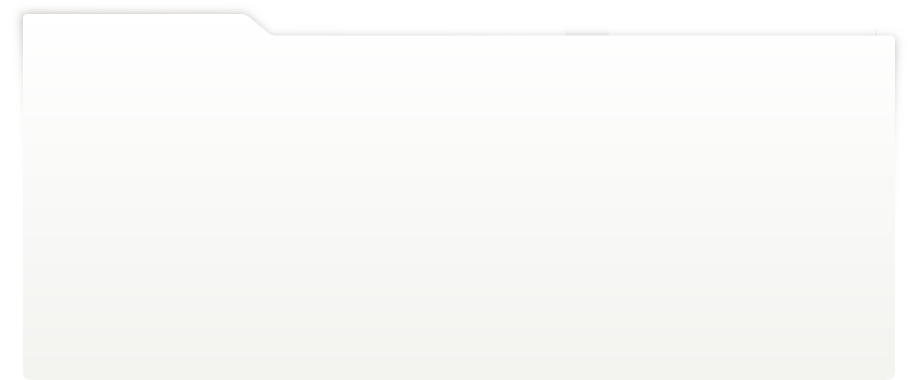
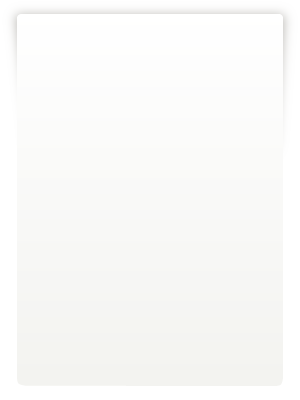
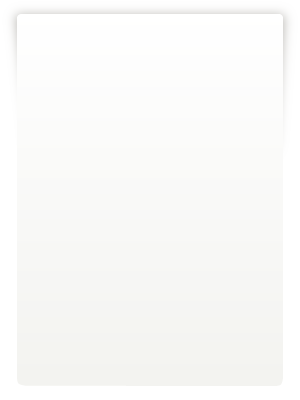
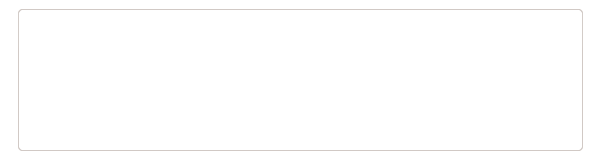
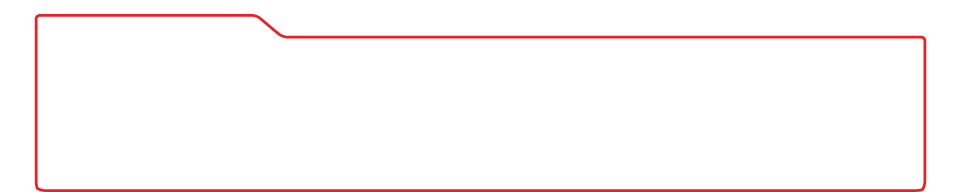
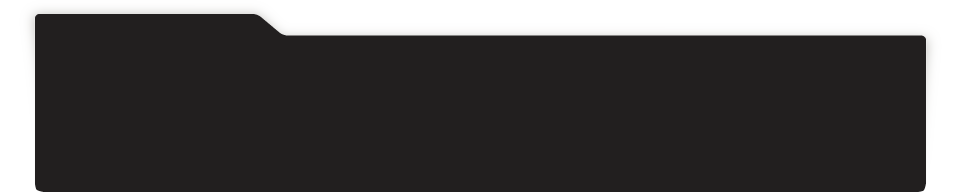
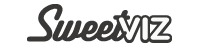
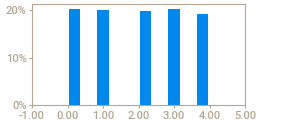
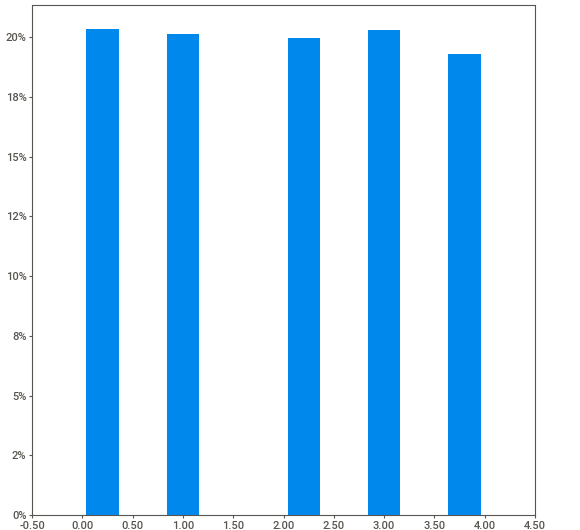
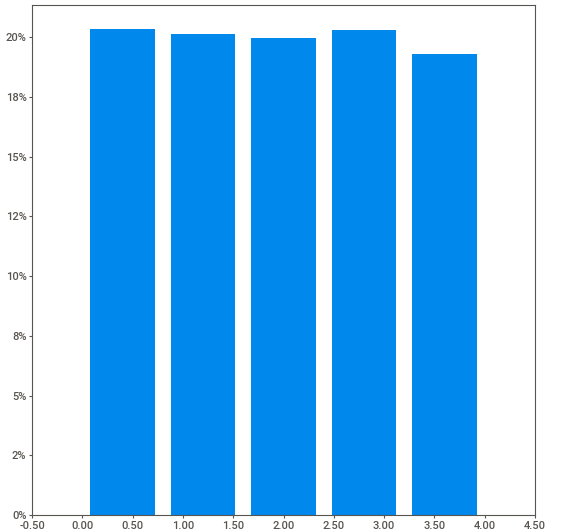
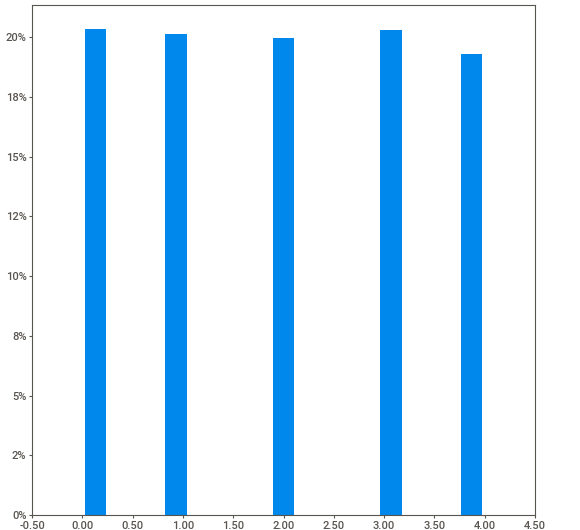
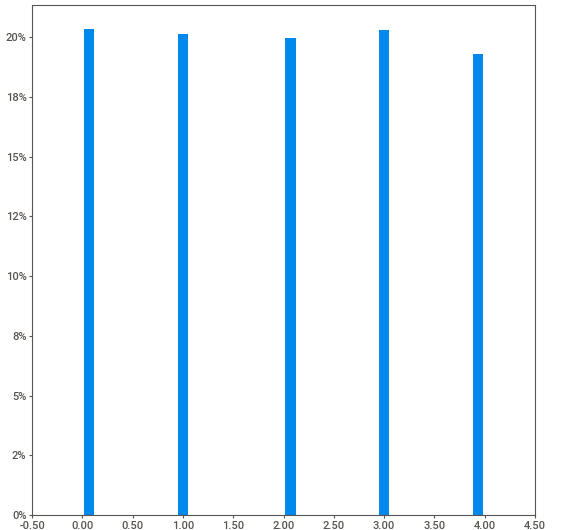
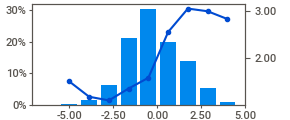
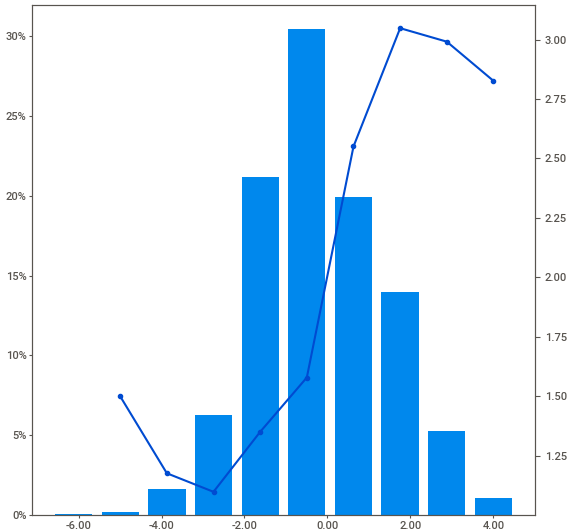
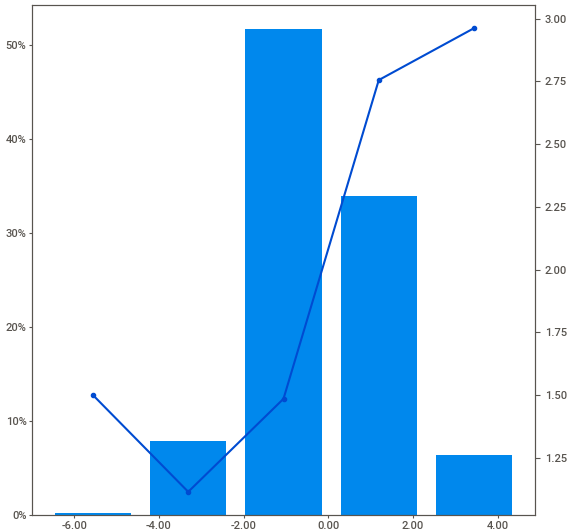
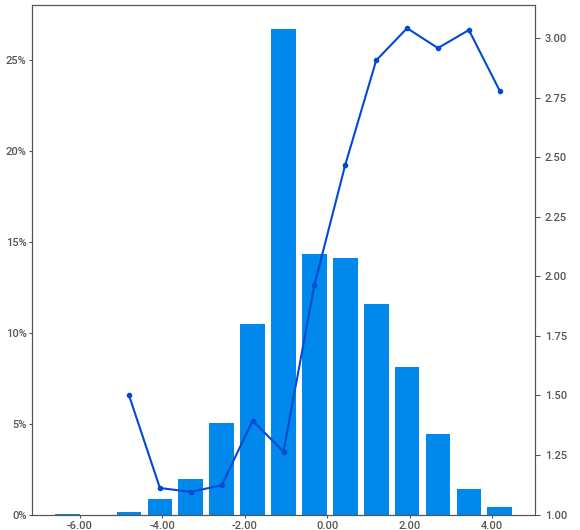
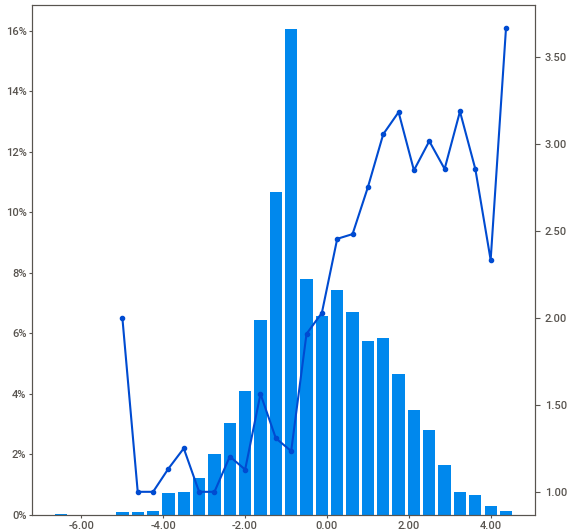
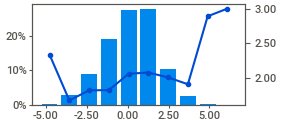
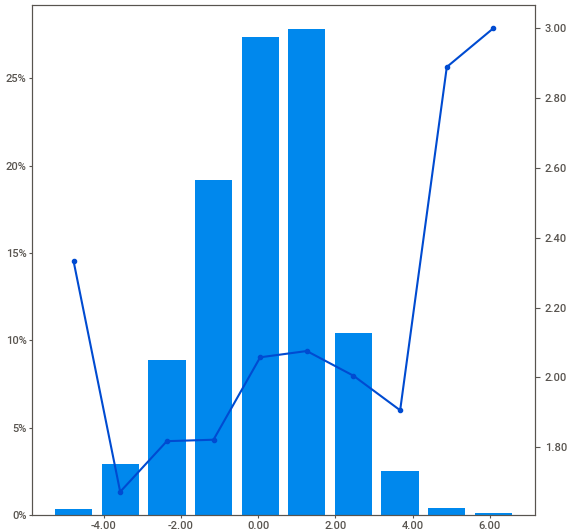
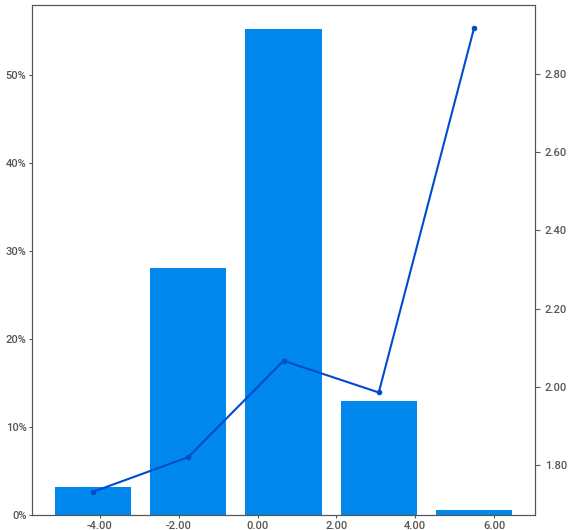
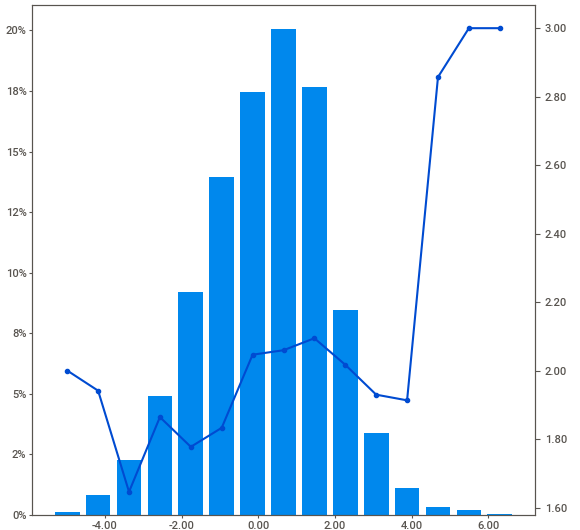
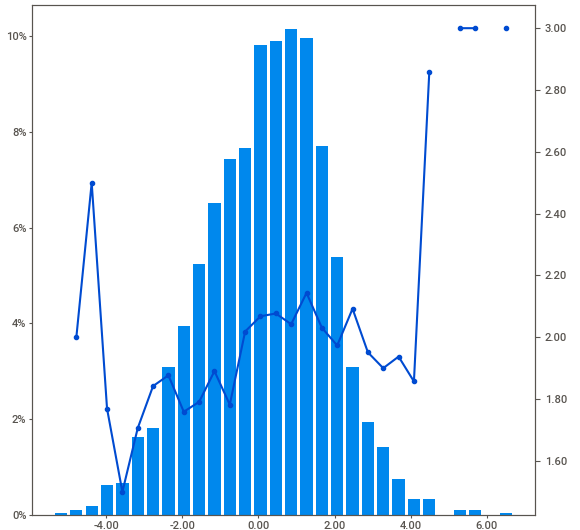
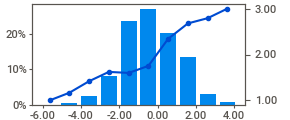
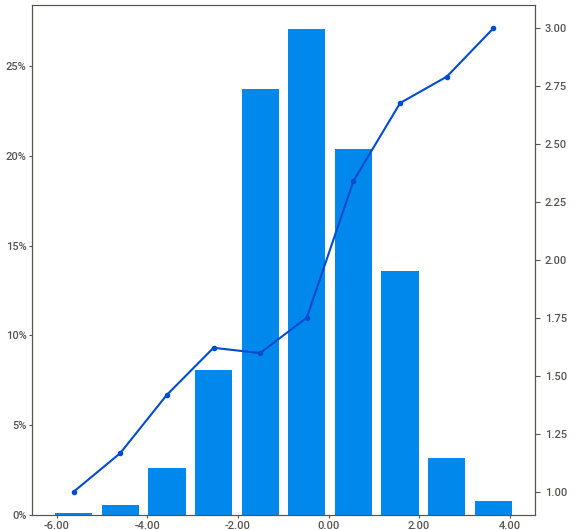
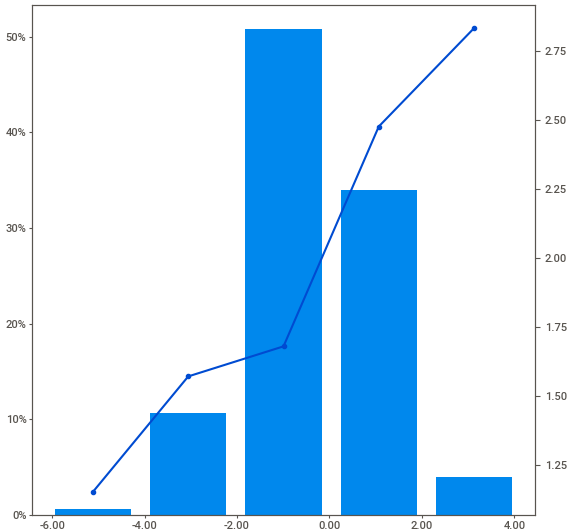
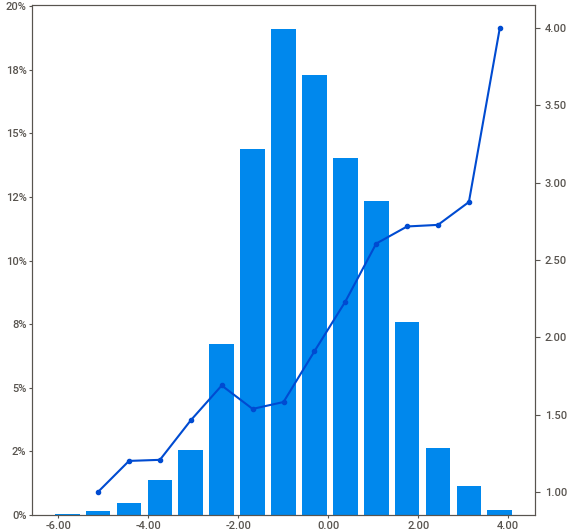
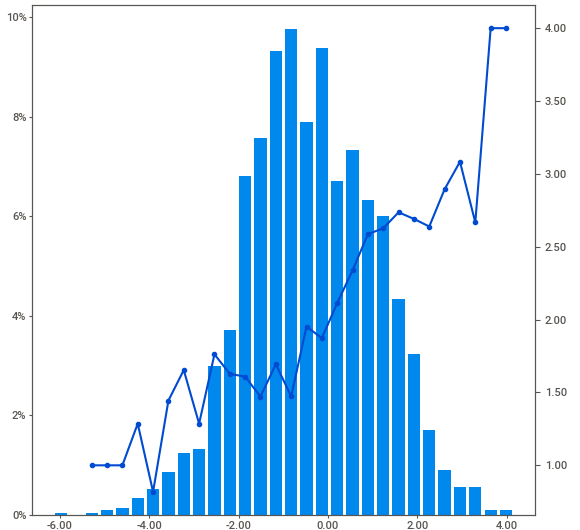
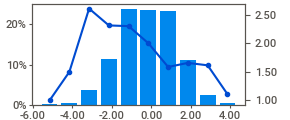
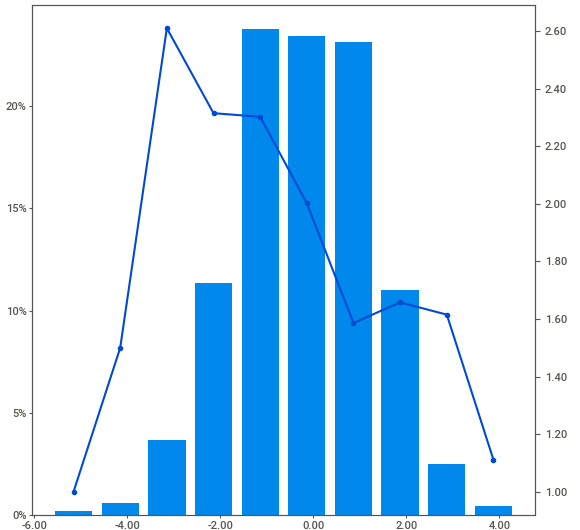
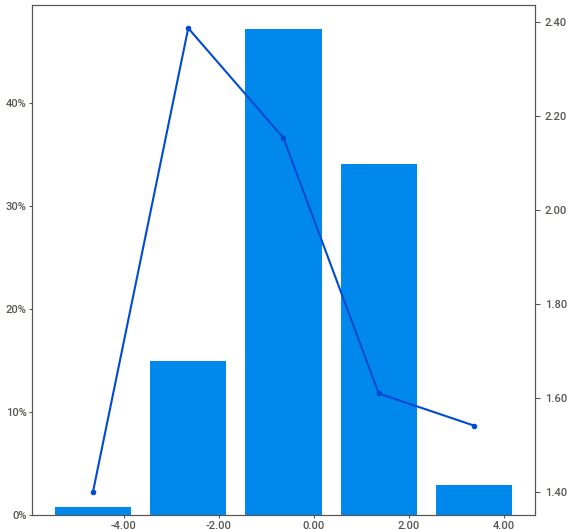
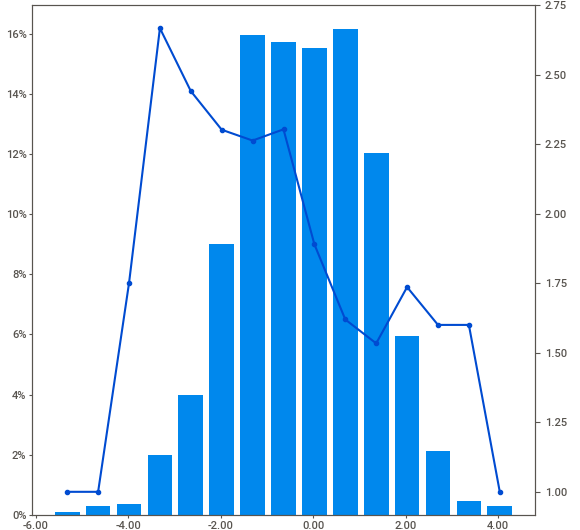
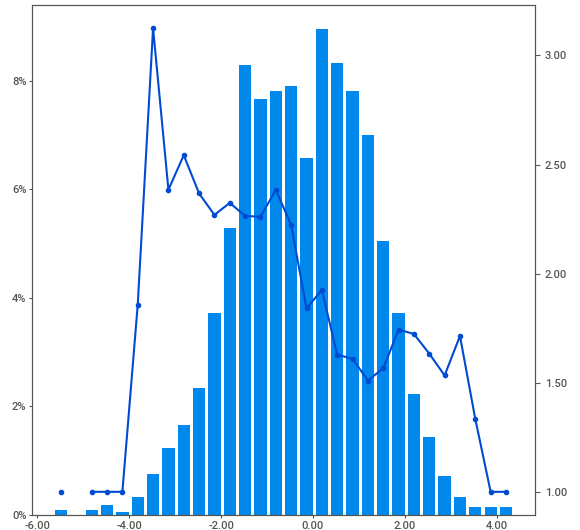
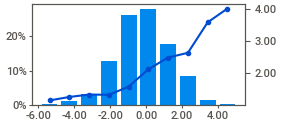
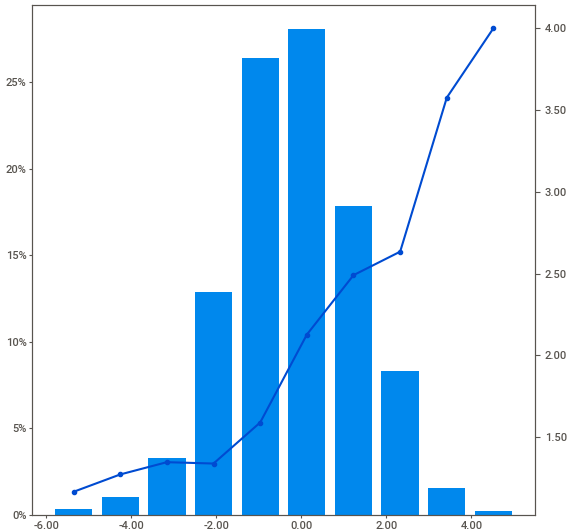
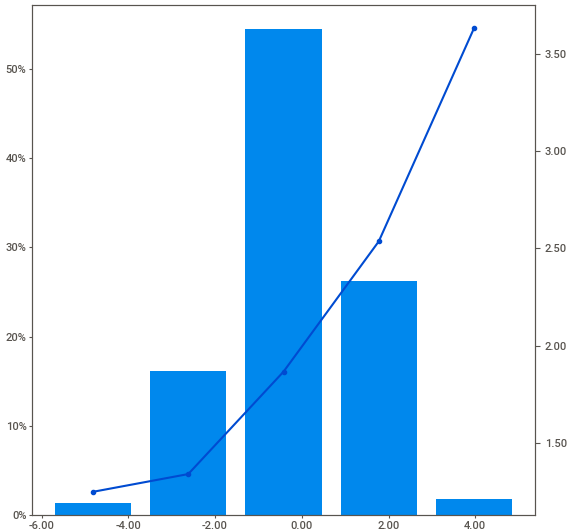
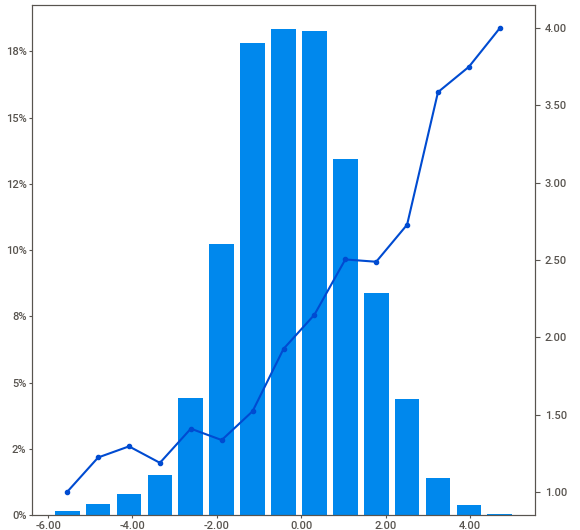
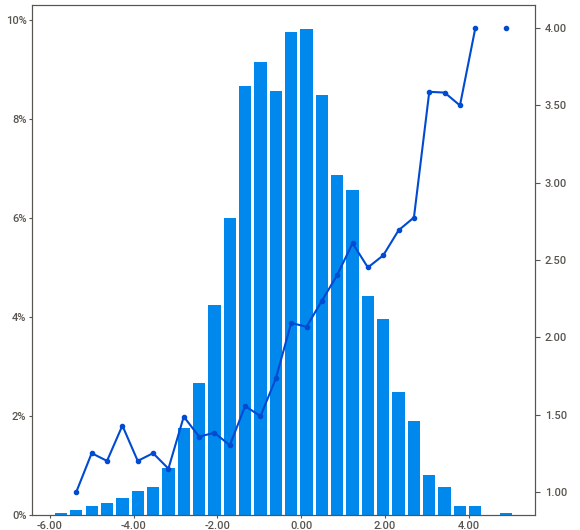
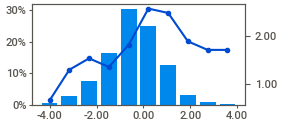
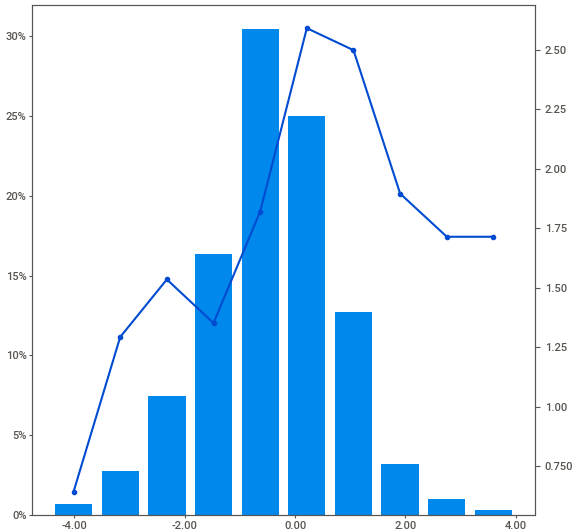
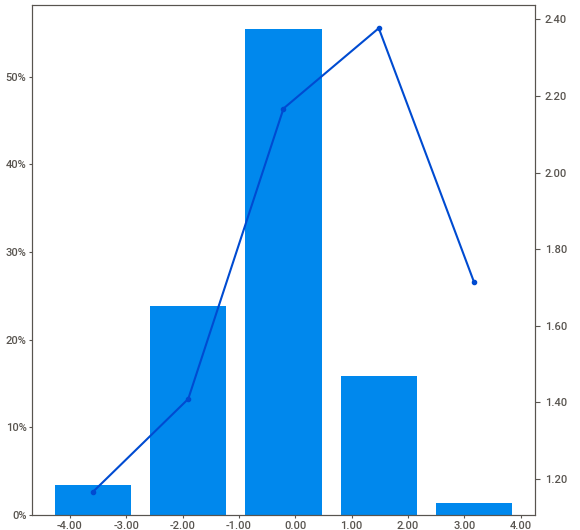
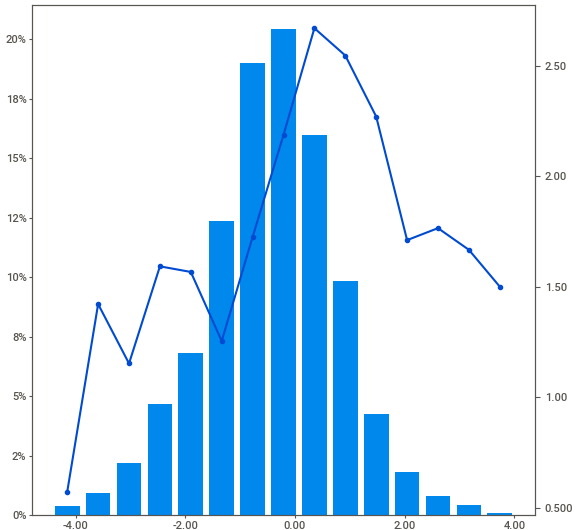
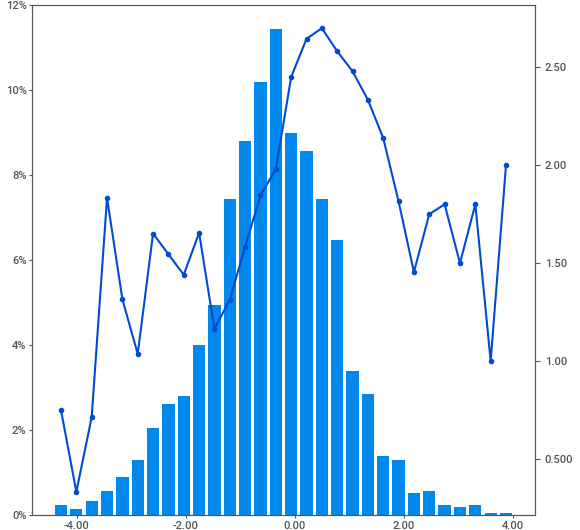
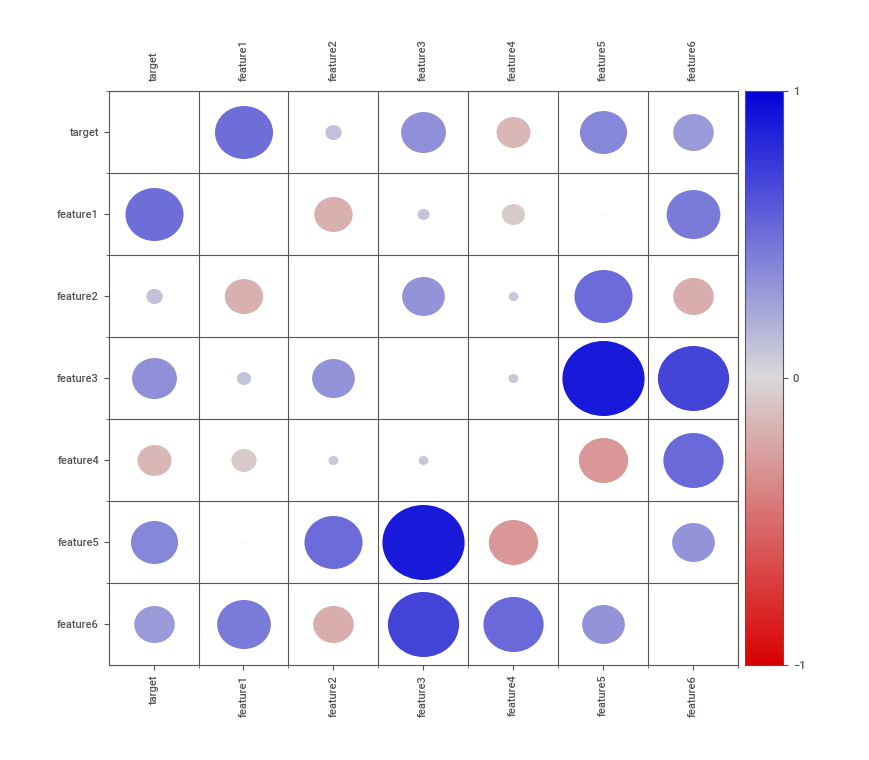
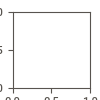

Report 'C:\Users\march\000 Treball Ju`yter 000\Hackathons\Access_Job_Talent_Oct_2022\new_files\train_EDA.html' was saved to storage.


In [5]:
#display the train report
volcano_train_report.show_notebook( w=None, 
                                    h=None, 
                                    scale=None,
                                    layout='vertical',
                                    filepath='C:\\Users\\march\\000 Treball Ju`yter 000\\Hackathons\\Access_Job_Talent_Oct_2022\\new_files\\train_EDA.html')


From the previous analysis, it can be observed several facts:

 - No null values in all the dataframe.
 - Features have a gaussian type distribution with an average value around 0.
 - Label's distribution is balanced

Comparing test and train datasets with Sweetviz:

In [6]:
comparison_report = sv.compare([volcano_train, "Training Data"], [volcano_test, "Test Data"], "target", feature_config)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:03 -> (00:00 left)



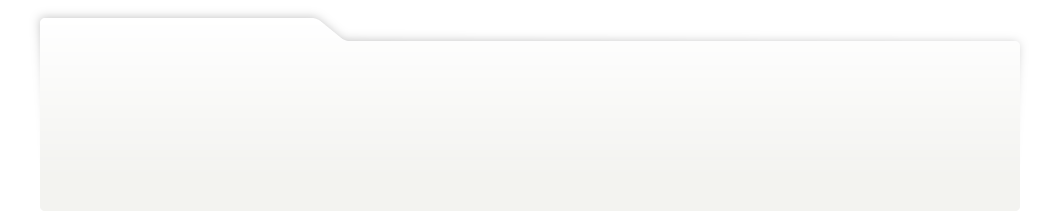
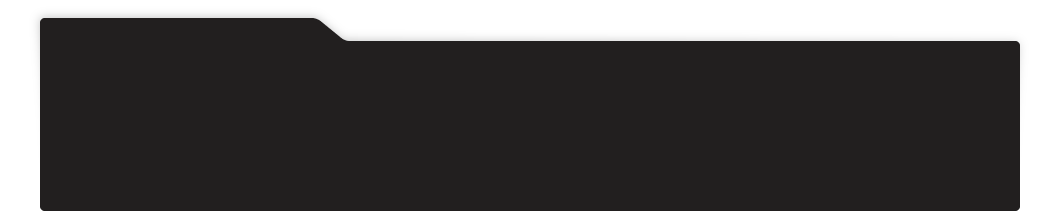
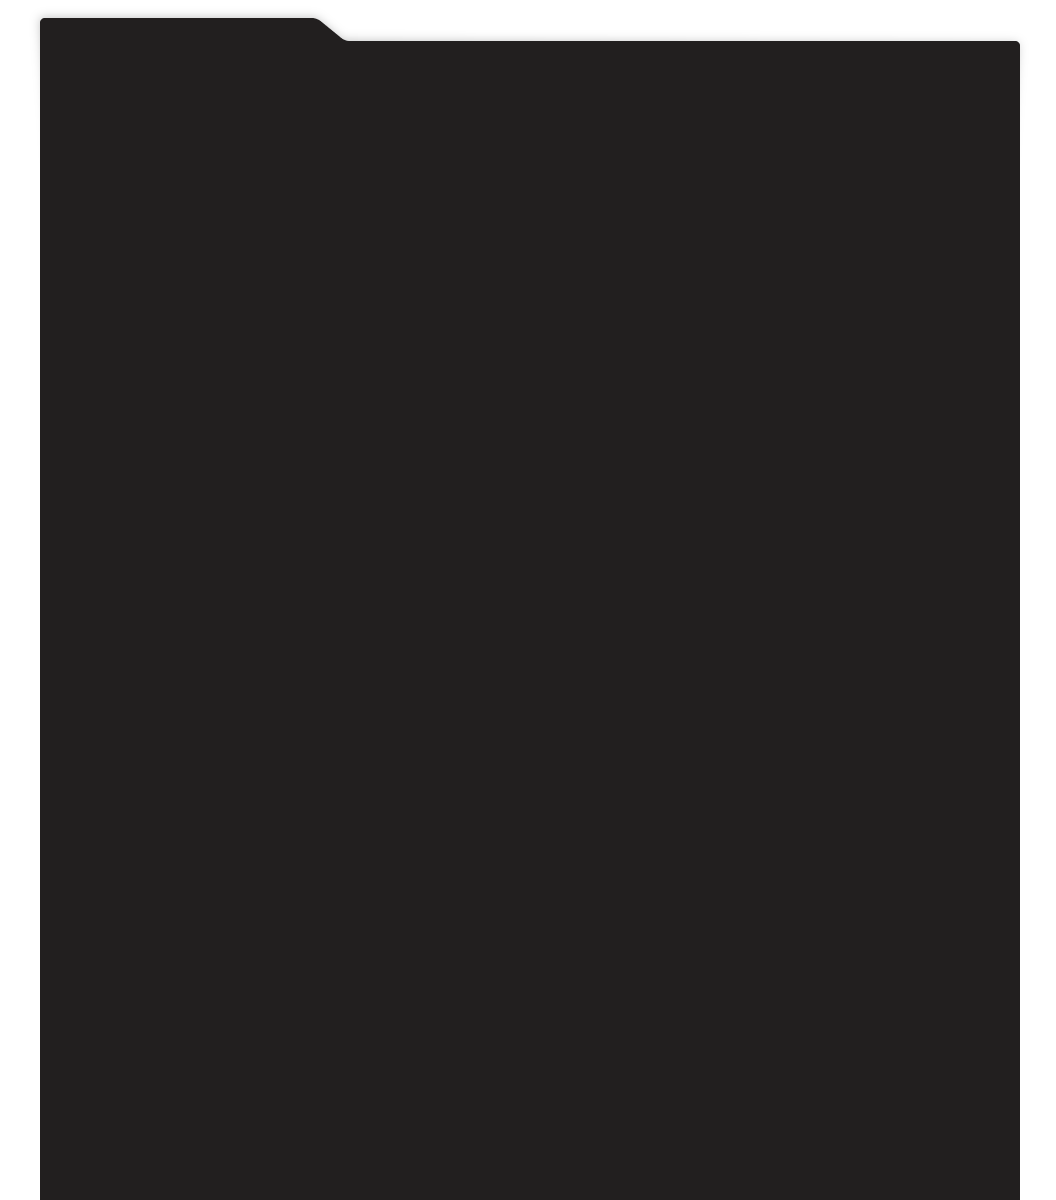
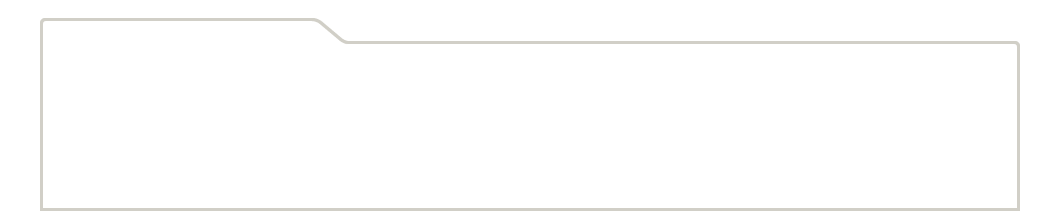
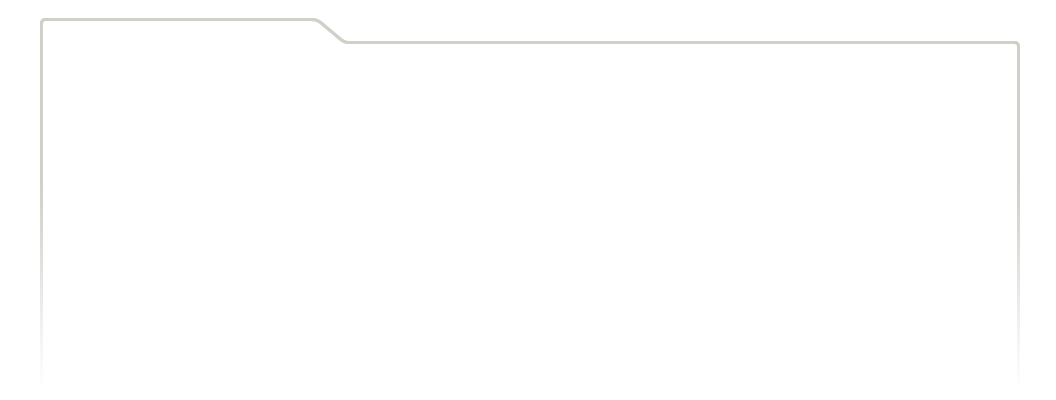
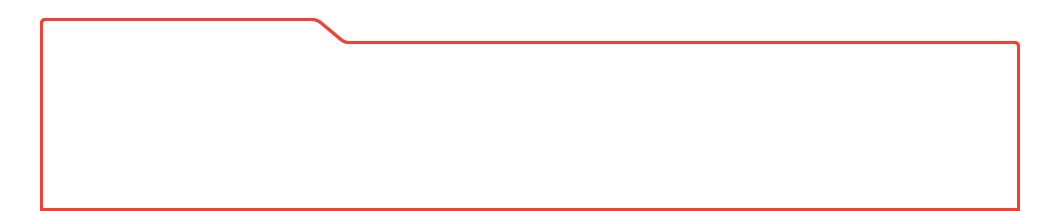
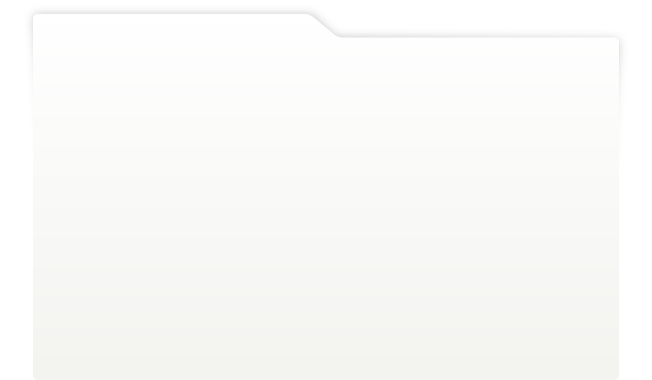
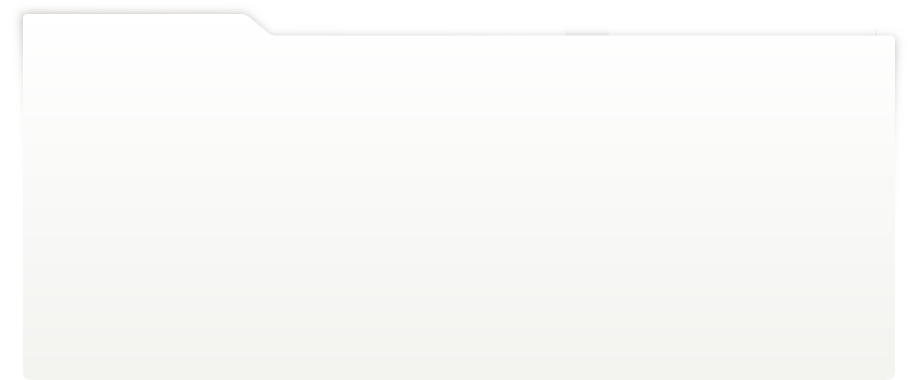
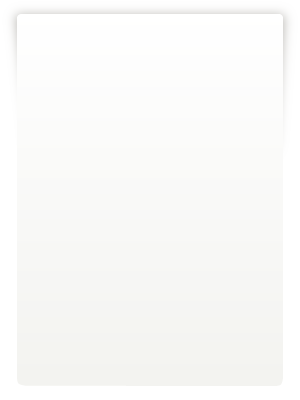
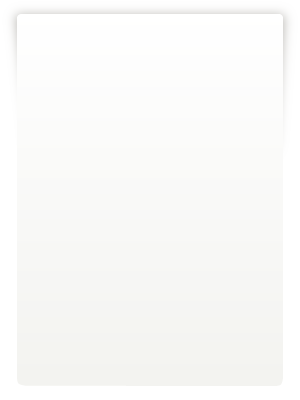
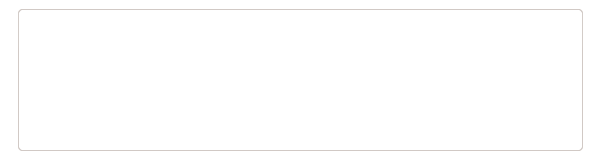
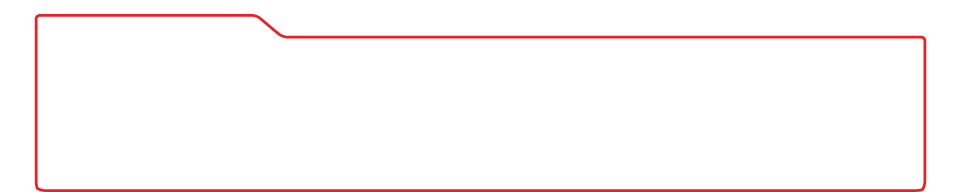
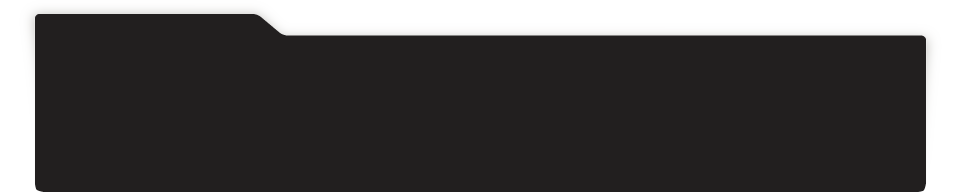
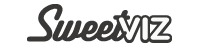
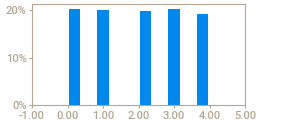
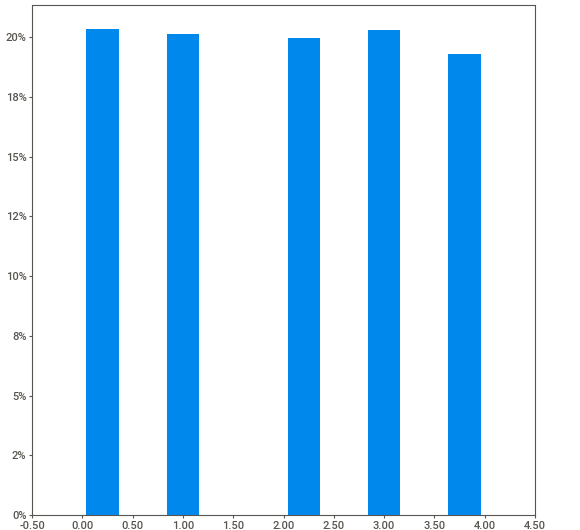
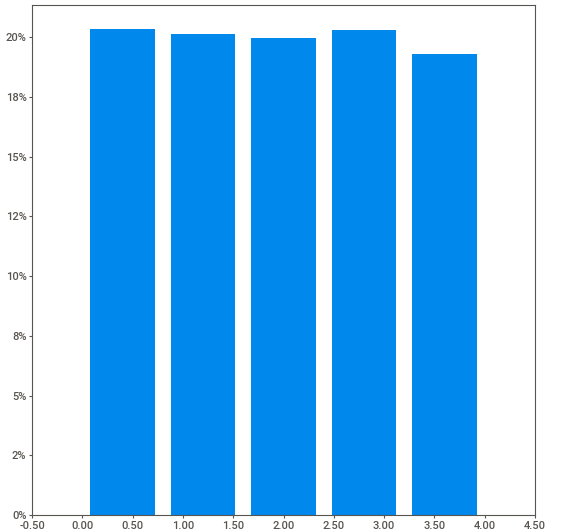
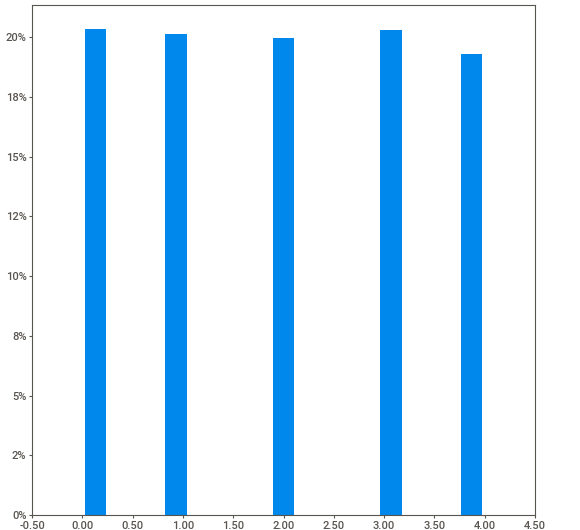
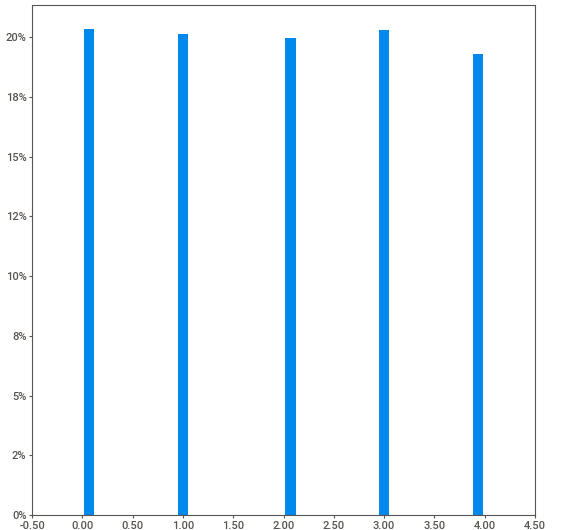
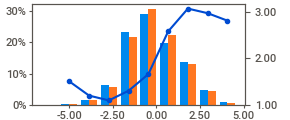
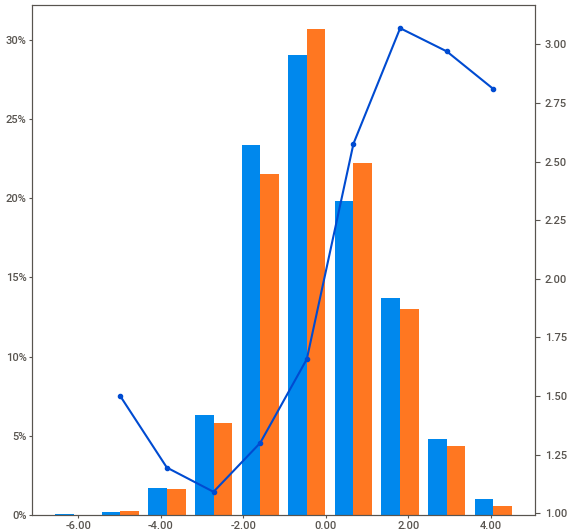
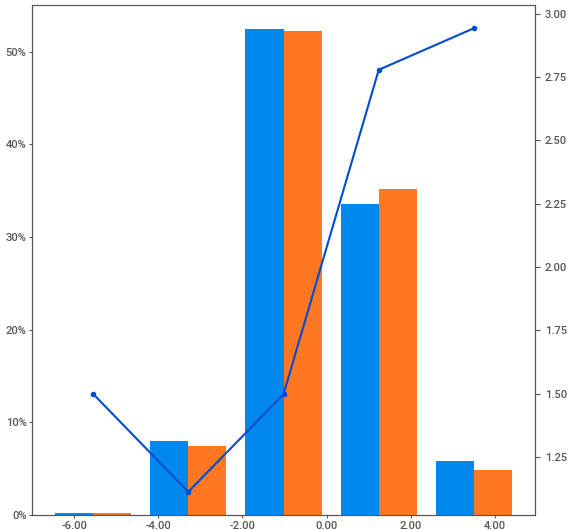
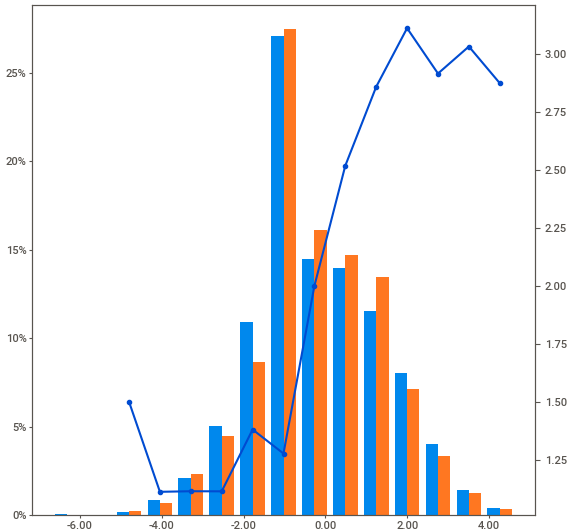
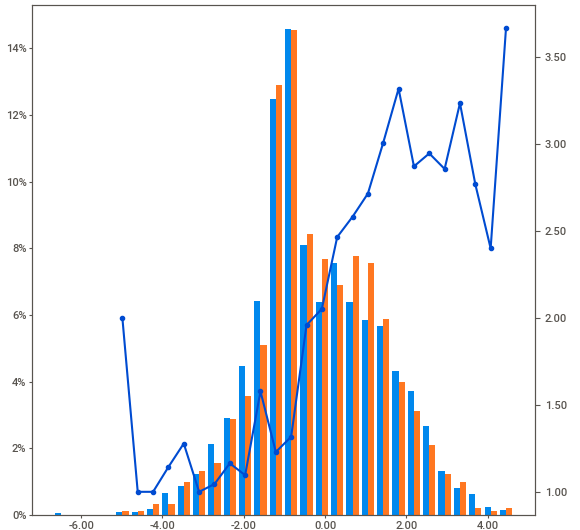
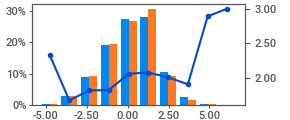
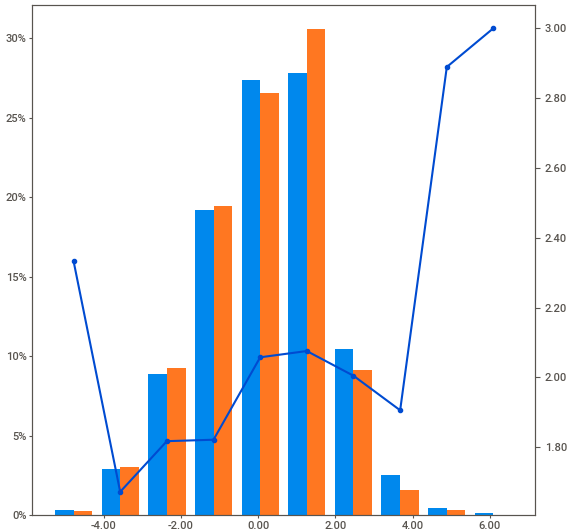
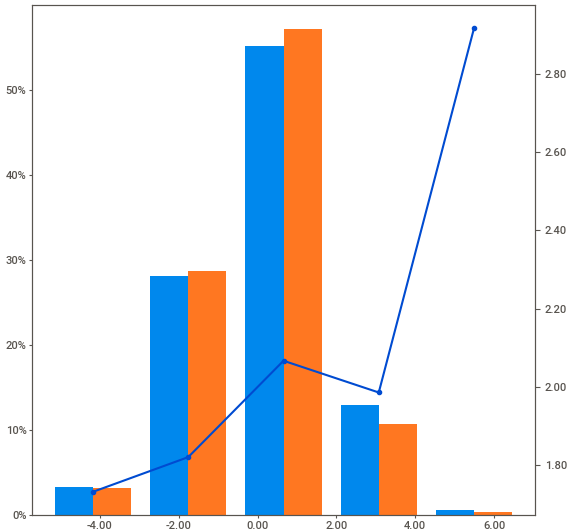
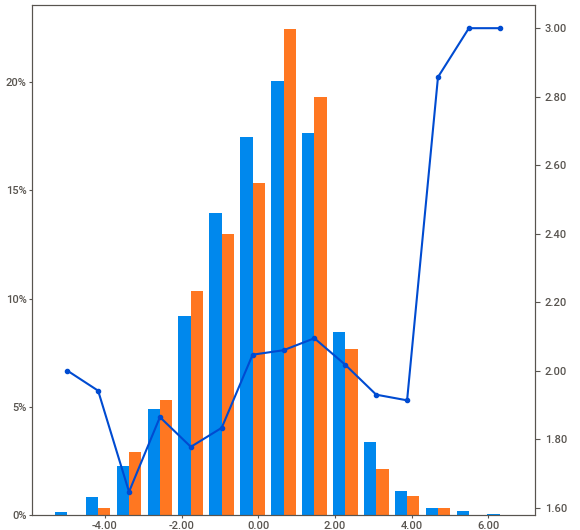
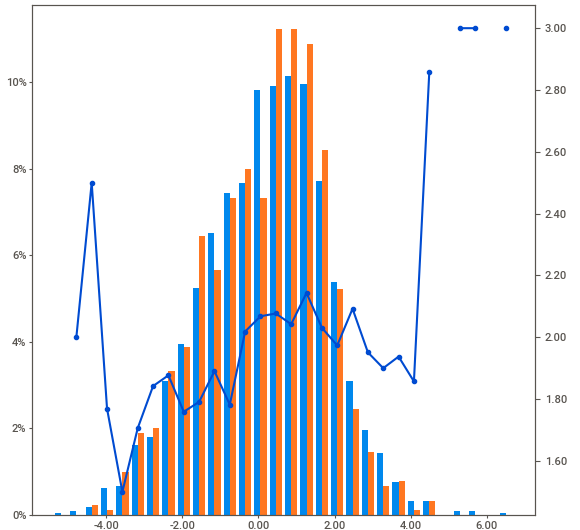
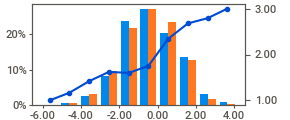
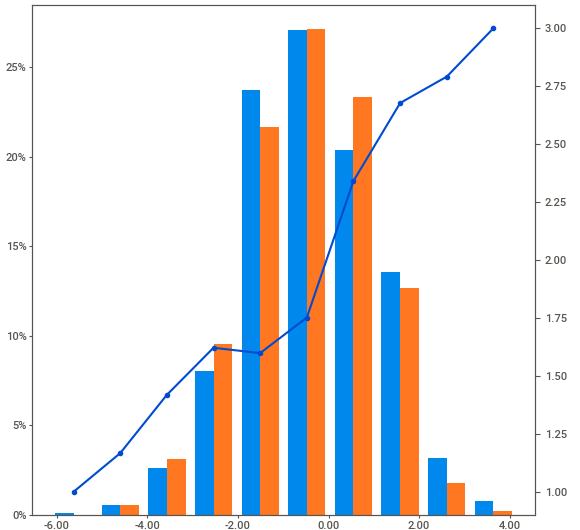
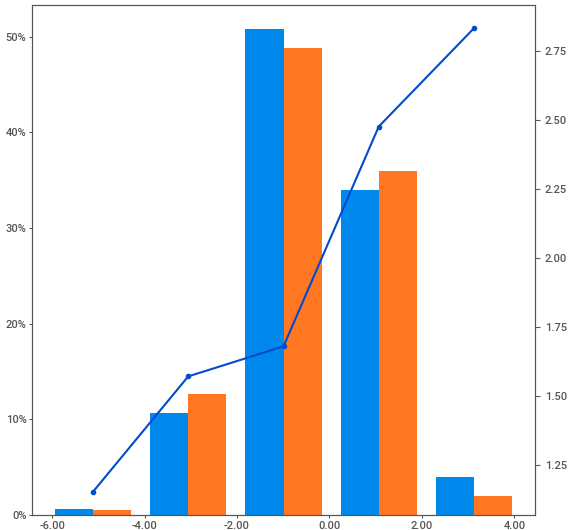
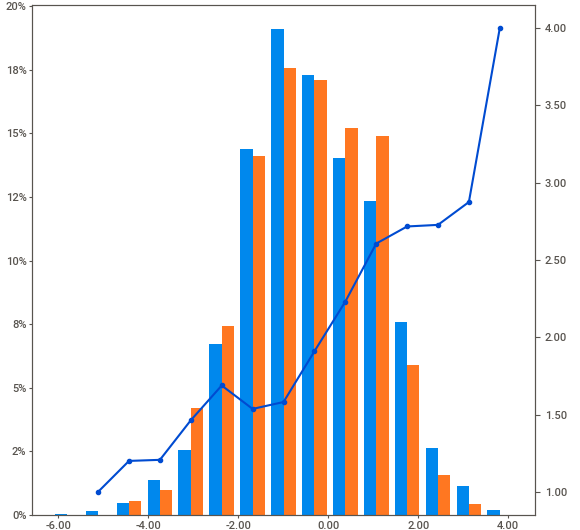
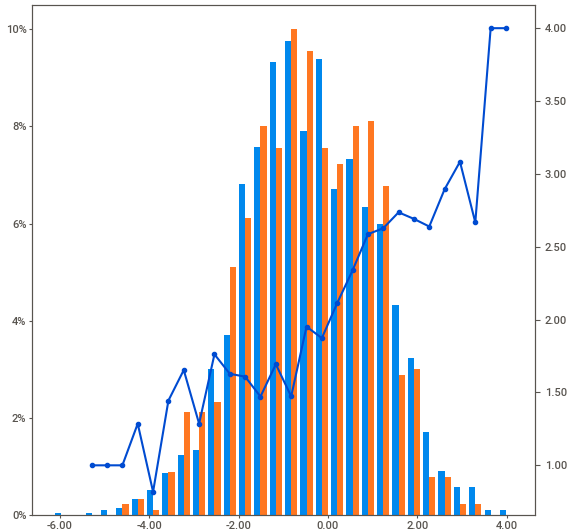
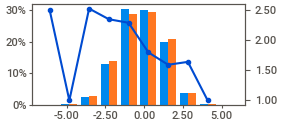
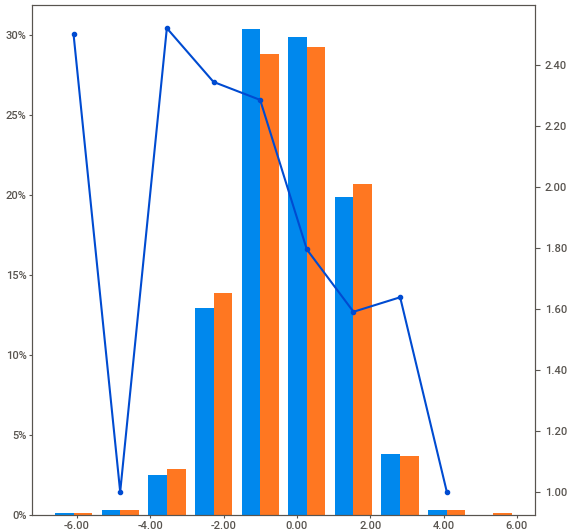
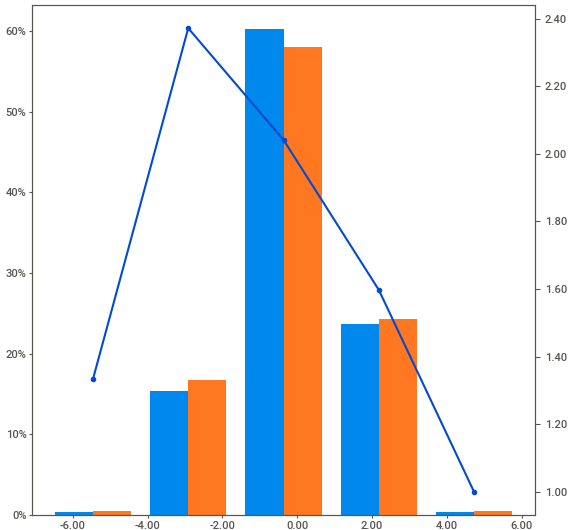
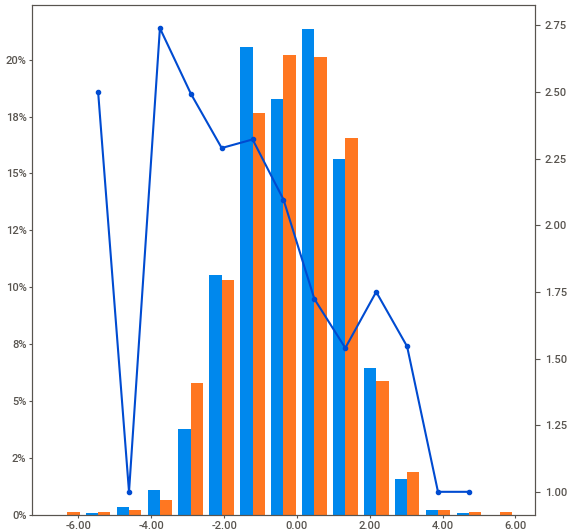
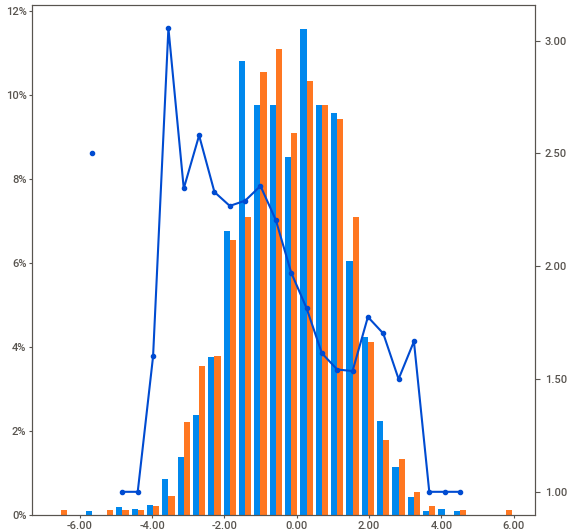
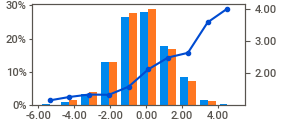
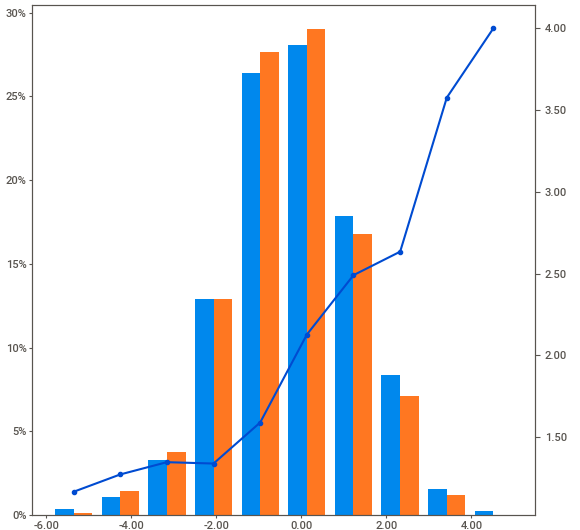
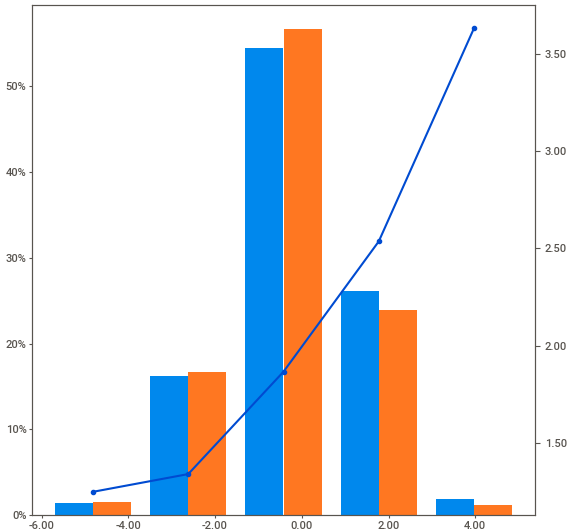
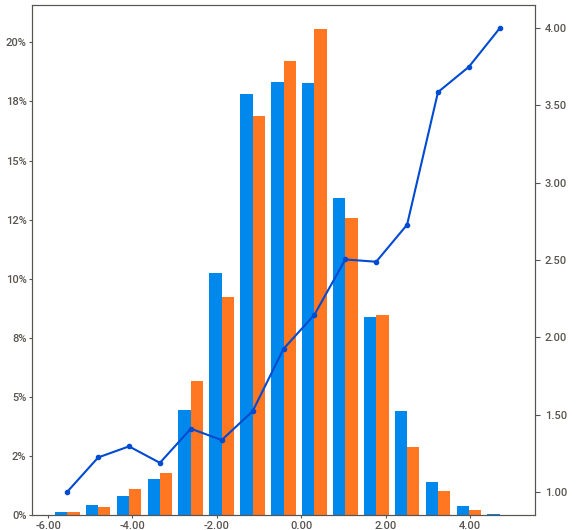
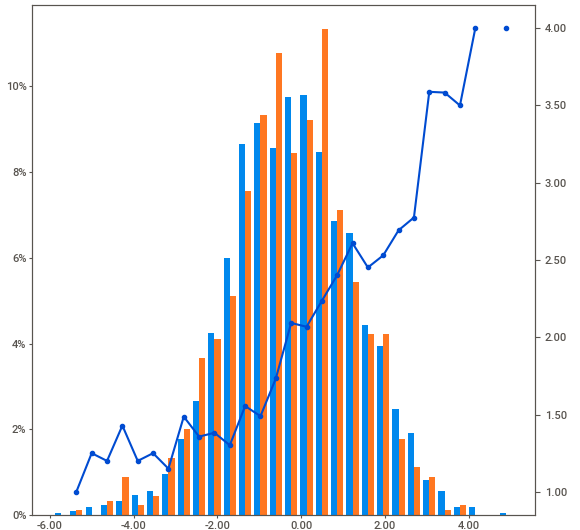
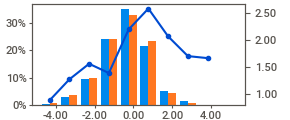
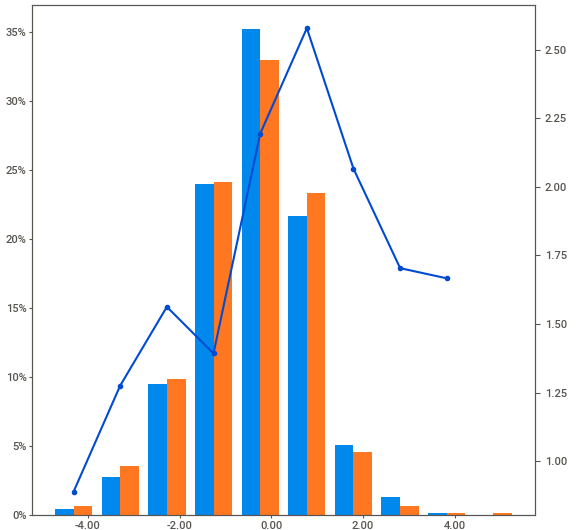
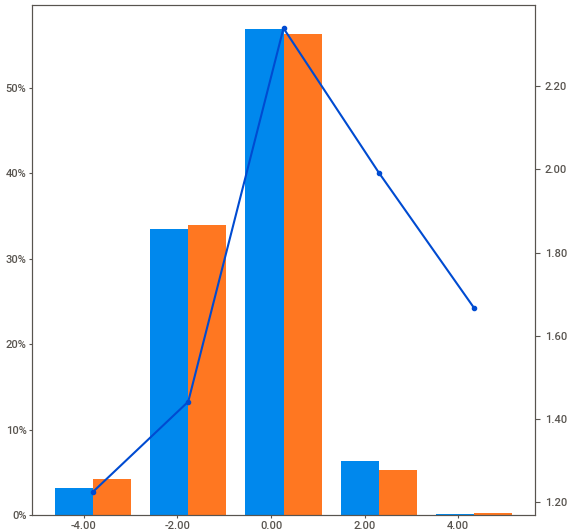
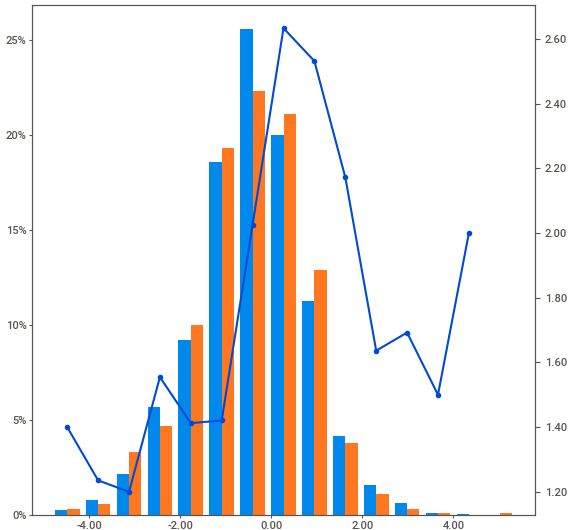
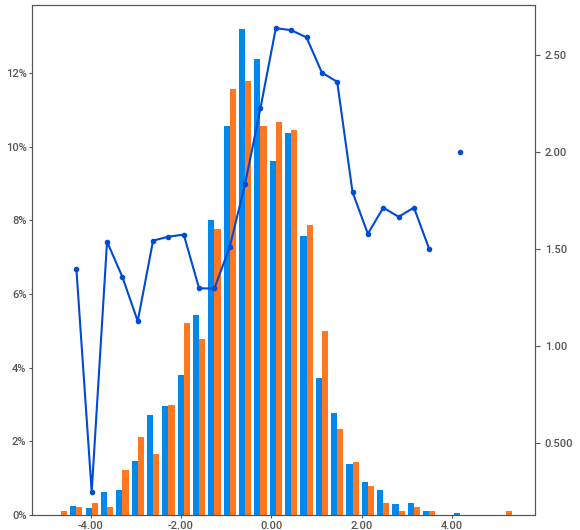
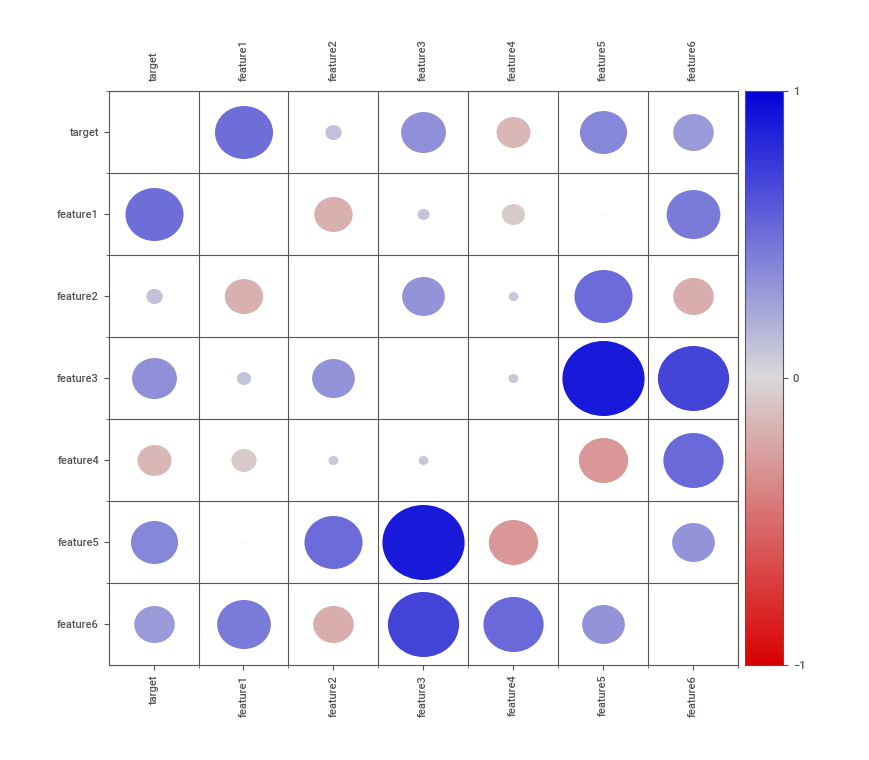
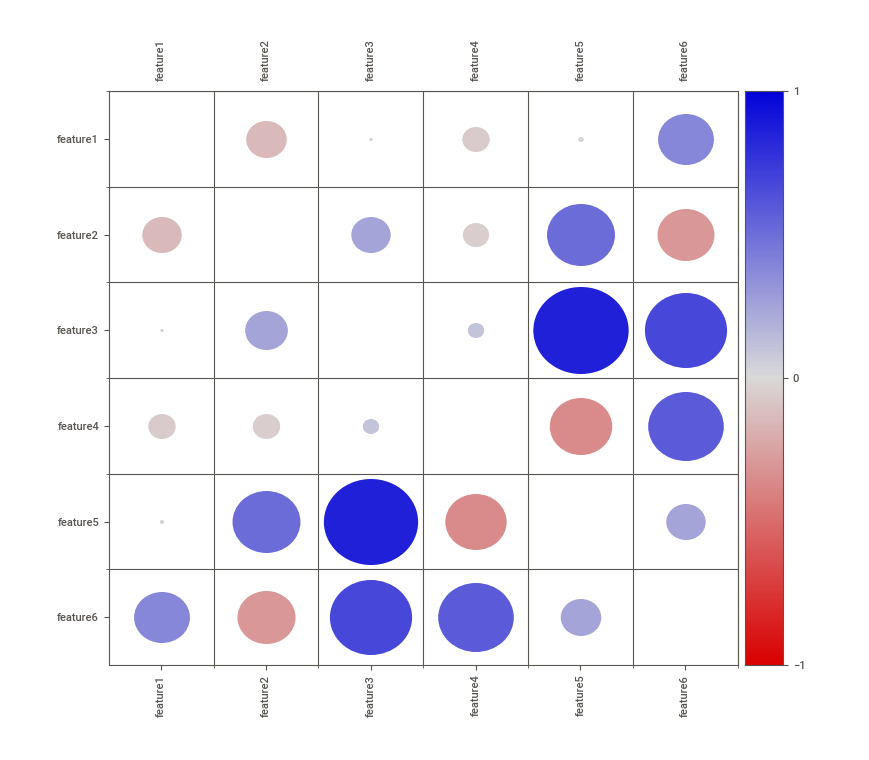

Report 'C:\Users\march\000 Treball Ju`yter 000\Hackathons\Access_Job_Talent_Oct_2022\new_files\test_vs_train_EDA.html' was saved to storage.


In [7]:
#display the train report
comparison_report.show_notebook( w=None, 
                                h=None, 
                                scale=None,
                                layout='vertical',
                                filepath='C:\\Users\\march\\000 Treball Ju`yter 000\\Hackathons\\Access_Job_Talent_Oct_2022\\new_files\\test_vs_train_EDA.html')

Train and test data sets have a similar data distribution (excluding the label/target column).

Text(0.5, 0.98, 'Pair plot of sensors with status label differentiation')

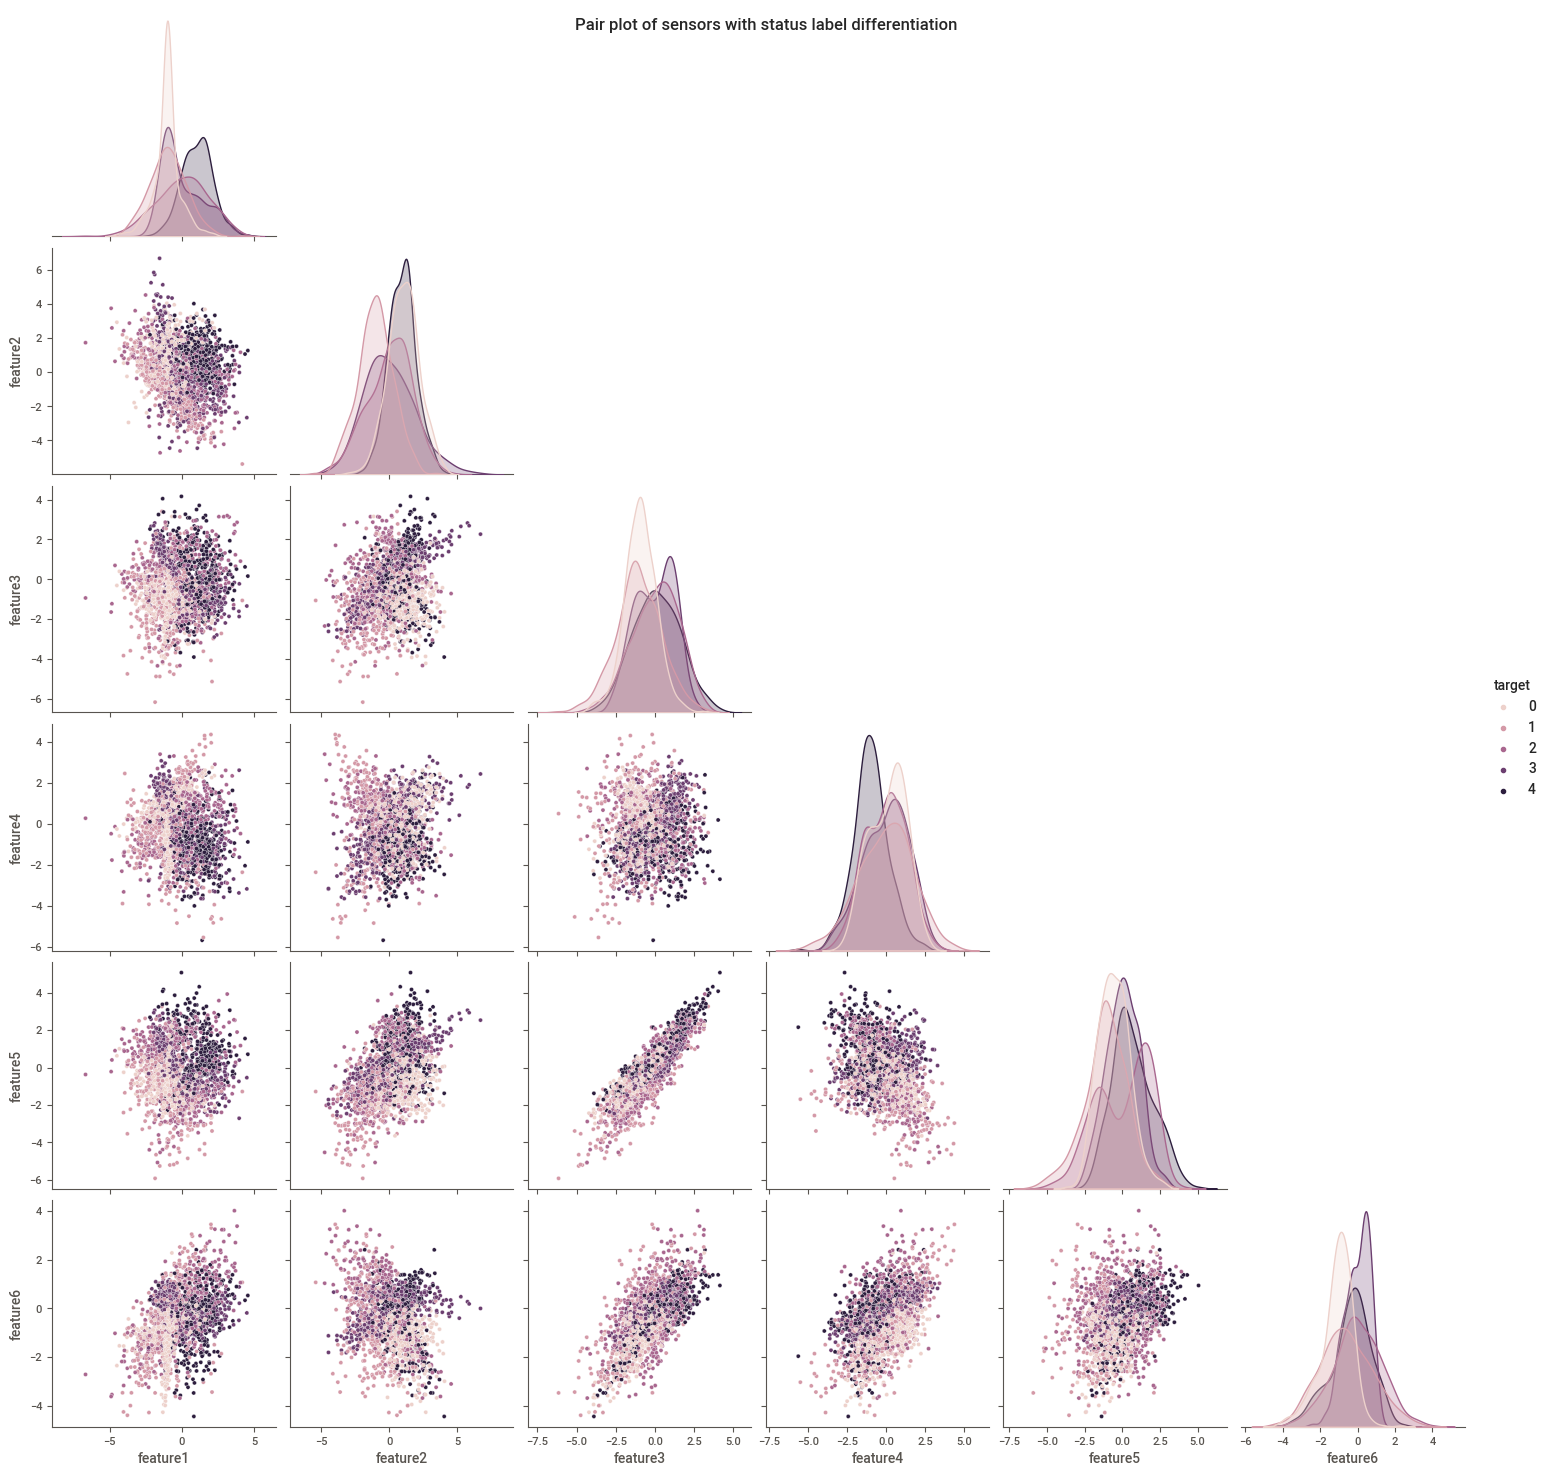

In [8]:
pairplot_volcanos = sns.pairplot(volcano_train, corner=True,hue='target')
pairplot_volcanos.fig.suptitle('Pair plot of sensors with status label differentiation')

From the previous graph it can be concluded that:
* Each class has a gaussian type distribution.
* The different labels form clusters for certain sensors, such differences are the ground of predictions.

Text(0.5, 1.0, 'Correlation of values of different sensors')

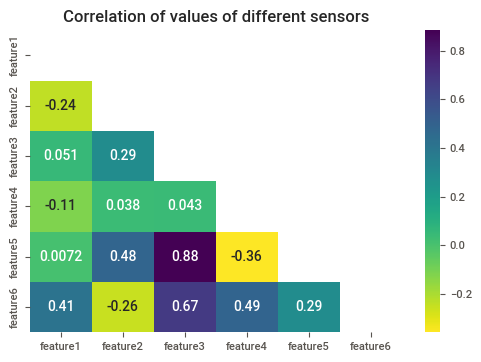

In [9]:
# Getting the Lower Triangle of the co-relation matrix
matrix = np.triu(volcano_train.drop('target',axis =1).corr())
sheatmap_correlations_sensors = sns.heatmap(volcano_train.drop('target',axis =1).corr(), annot=True, cmap='viridis_r', mask=matrix)
sheatmap_correlations_sensors.set_title('Correlation of values of different sensors')

Features 3 and 5 are highly correlated but it does not involve a correlation with the differents labels/status.

# 2. Data Engineering

## Dimension Reduction (PCA)

In [35]:
x=volcano_train.copy()
x.drop('target',axis=1, inplace =True)


To study the influence of the dimensional reduction of features, initial dataframe was reduced to 3,4 and 5 dimensions. 

PCA fitted objects, arrays of transformed inital dataframe and its corresponging dataframes (with named columns) were stored in a dictionary named pca_study.

In [57]:
pca_study = {}
columns_pca=['PC1','PC2','PC3','PC4','PC5']
for i in range(3,6):
    pca_study [i] = PCA(n_components=i)
    pca_study [i].fit(x)
    pca_study ['x_pca_'+str(i)] = pca_study [i].transform(x)
    pca_study ['x_pca_'+str(i)+'_df'] = pd.DataFrame(pca_study ['x_pca_'+str(i)], columns=columns_pca[0:i])
    #if i ==3:
    pca_study ['x_pca_'+str(i)+'_var'] = pca_study [i].explained_variance_ratio_
    #else: 
    #    pca_study ['x_pca_'+str(i)+'_var'] = pca_study ['x_pca_'+str(i-1)+'_var'] + pca_study [i].explained_variance_ratio_


In [69]:
variance = pca_study ['x_pca_5_var'] 
variance_cumulative =  np.cumsum(pca_study ['x_pca_5_var'] )

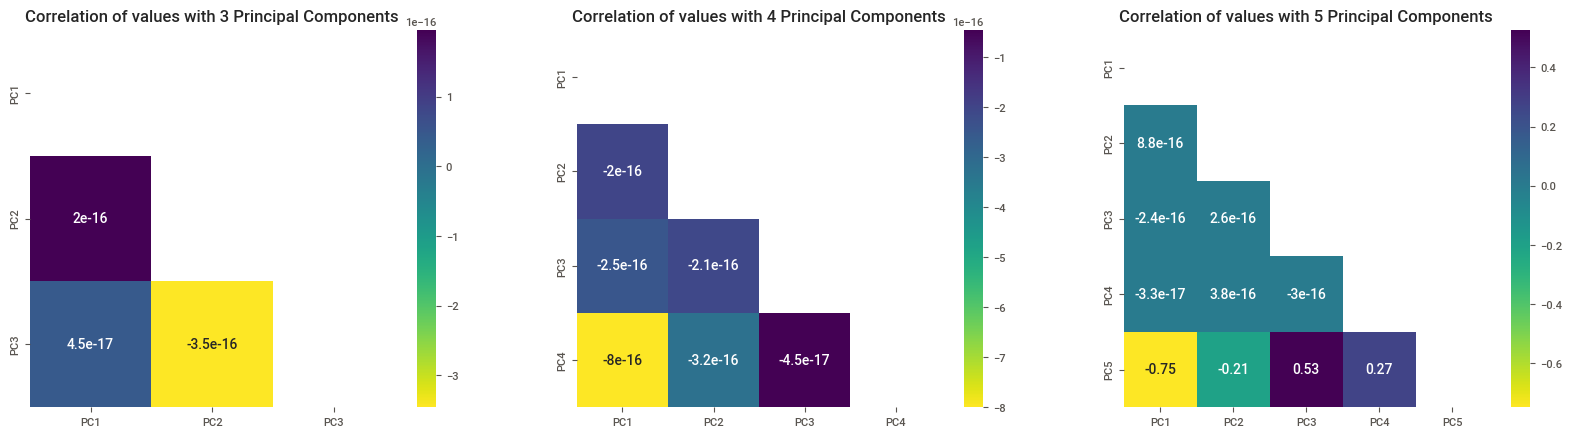

In [52]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize =(20, 5))
j=3
sheatmap_PCA_reduction_={}
for axx in [ax1, ax2, ax3]:
    matrix = np.triu(pca_study ['x_pca_'+str(j)+'_df'].corr())
    sheatmap_PCA_reduction_[j] = sns.heatmap(pca_study ['x_pca_'+str(j)+'_df'].corr(), annot=True, cmap='viridis_r', mask=matrix, ax =axx)
    sheatmap_PCA_reduction_[j].set_title(f'Correlation of values with {j} Principal Components')
    j+=1
   
plt.show()

Reduction to 5 components does not mitigate correlation between them. It is required to reduce dimensionality to 4 or 3 to get correlation values lower than 0.5 (absolute values). Let's check the loss of variance that could affect model performance for classification prediciton.

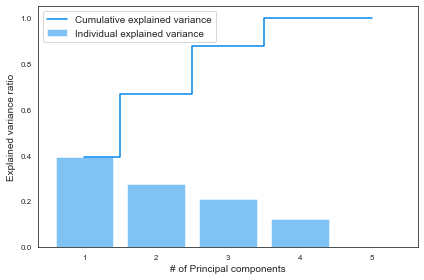

In [73]:
# Create the visualization plot
#
plt.bar(range(1,len(variance)+1), variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1,len(variance_cumulative)+1), variance_cumulative, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('# of Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

With reduction to 4 or 5 components, no loss on the explained variance was observed (explained variance = 1.0!). As with 4 principal component there is no loss of explained variance and correlation between components is avoided, 4 principal component is the choice to perform testing on models and see if the correlation between features can affect model performance. Data transformed is in the dictionary as pca_study['x_pca_4'].
Please check in [the next setion](##-Impact-of-PCA-study-in-model-performance) for the impact on model classification performance.

## Data scaling

There is no need to clean, and some data engineering on the Data set can be tested. Let's consider to check normalization, standarization and treating outliers with robustscaler:

In [10]:
volcano_train.columns

Index(['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6',
       'target'],
      dtype='object')

In [11]:
x = volcano_train.copy()
x = volcano_train.drop('target',axis=1).values #returns a numpy array
numerical_cols=['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6']
y= volcano_train.target


In [12]:

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
volcano_train_min_max_scaled = pd.DataFrame(x_scaled, columns =numerical_cols)


In [13]:

scaler = preprocessing.RobustScaler()
volcano_train_robust = scaler.fit_transform(x)
volcano_train_robust = pd.DataFrame(volcano_train_robust, columns =numerical_cols)


In [14]:

scaler = preprocessing.StandardScaler()
volcano_train_standard = scaler.fit_transform(x)
volcano_train_standard = pd.DataFrame(volcano_train_standard, columns =numerical_cols)


In [15]:
volcano_train_min_max_scaled ['target'] = volcano_train['target']
volcano_train_robust ['target'] = volcano_train['target']
volcano_train_standard ['target'] = volcano_train['target']


Let's check the change through graphical visualisation of initial data vs scaled with density plots. Each graph contains 2 features. Accordingly there is 3 graphs for each set of values to include all the 6 features (for more clarity on visualizations).  

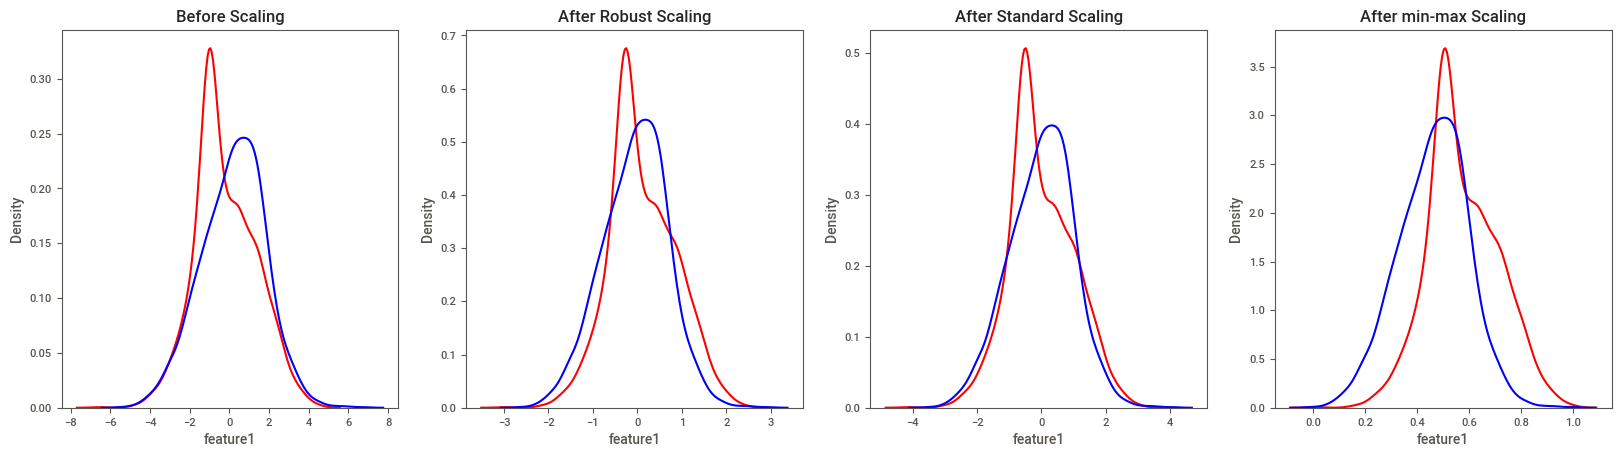

In [16]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))

ax4.set_title('After min-max Scaling')
sns.kdeplot(volcano_train_min_max_scaled['feature1'], ax = ax4, color ='r')
sns.kdeplot(volcano_train_min_max_scaled['feature2'], ax = ax4, color ='b')

ax2.set_title('After Robust Scaling')  
sns.kdeplot(volcano_train_robust['feature1'], ax = ax2, color ='red')
sns.kdeplot(volcano_train_robust['feature2'], ax = ax2, color ='blue')

ax3.set_title('After Standard Scaling')  
sns.kdeplot(volcano_train_standard['feature1'], ax = ax3, color ='red')
sns.kdeplot(volcano_train_standard['feature2'], ax = ax3, color ='blue')

ax1.set_title('Before Scaling') 
sns.kdeplot(volcano_train['feature1'], ax = ax1, color ='red')
sns.kdeplot(volcano_train['feature2'], ax = ax1, color ='blue')
plt.show()

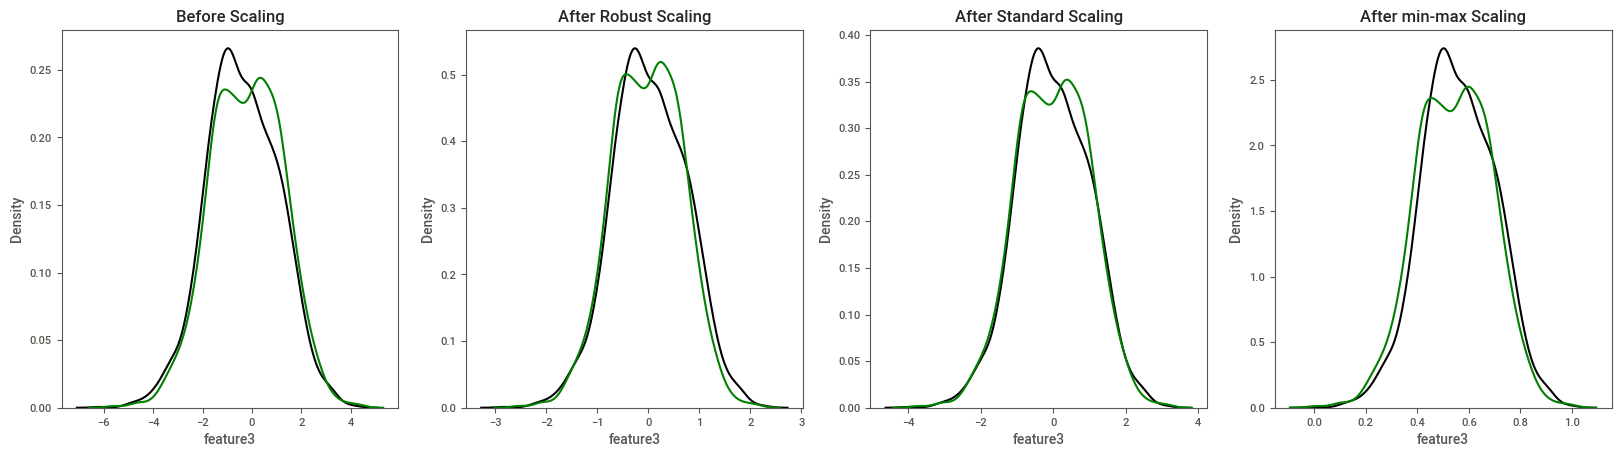

In [17]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))

ax4.set_title('After min-max Scaling')
sns.kdeplot(volcano_train_min_max_scaled['feature3'], ax = ax4, color ='black')
sns.kdeplot(volcano_train_min_max_scaled['feature4'], ax = ax4, color ='green')

ax2.set_title('After Robust Scaling')  
sns.kdeplot(volcano_train_robust['feature3'], ax = ax2, color ='black')
sns.kdeplot(volcano_train_robust['feature4'], ax = ax2, color ='green')

ax3.set_title('After Standard Scaling')  
sns.kdeplot(volcano_train_standard['feature3'], ax = ax3, color ='black')
sns.kdeplot(volcano_train_standard['feature4'], ax = ax3, color ='green')

ax1.set_title('Before Scaling') 
sns.kdeplot(volcano_train['feature3'], ax = ax1, color ='black')
sns.kdeplot(volcano_train['feature4'], ax = ax1, color ='green')
plt.show()

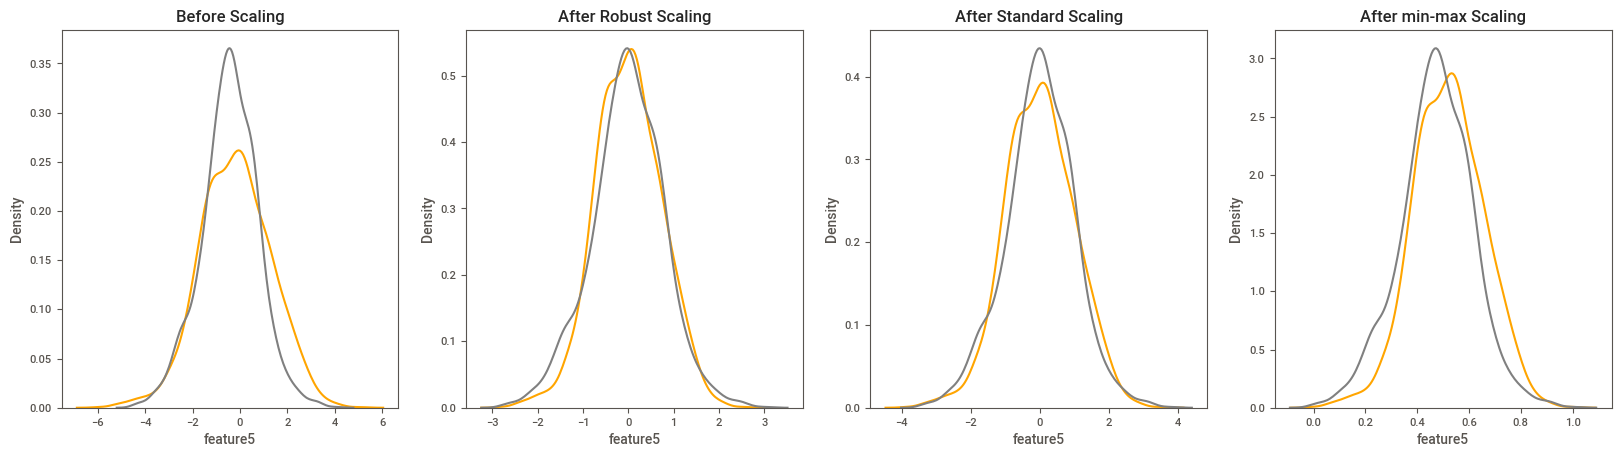

In [18]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))

ax4.set_title('After min-max Scaling')
sns.kdeplot(volcano_train_min_max_scaled['feature5'], ax = ax4, color ='orange')
sns.kdeplot(volcano_train_min_max_scaled['feature6'], ax = ax4, color ='grey')

ax2.set_title('After Robust Scaling')  
sns.kdeplot(volcano_train_robust['feature5'], ax = ax2, color ='orange')
sns.kdeplot(volcano_train_robust['feature6'], ax = ax2, color ='grey')

ax3.set_title('After Standard Scaling')  
sns.kdeplot(volcano_train_standard['feature5'], ax = ax3, color ='orange')
sns.kdeplot(volcano_train_standard['feature6'], ax = ax3, color ='grey')

ax1.set_title('Before Scaling') 
sns.kdeplot(volcano_train['feature5'], ax = ax1, color ='orange')
sns.kdeplot(volcano_train['feature6'], ax = ax1, color ='grey')
plt.show()

Differences on scaling is grafically visible but it may have no influence on the classification performance, let's study it in the[ next section](##-Scaled-Data).

# 3. Data engineering study with Pycaret

To compare the impact of data transformations done in the [previous section](#2.-Data-Engineering), screenings with the library Pycaret will be used to compare performance of classification models changing the training data set. As required initially by organisation, Random Forest will be the model of choice but all the screening will give a global idea of the impact of data engineering.

## Scaled Data

With Pycaret we compare the dataframe scaled in different ways (see previous section) through screening with several models to check its performance.

In [19]:
setup(volcano_train,
          target='target',
          session_id=42, 
          normalize = True,
          fold_strategy = 'stratifiedkfold', 
          verbose =False ,
          silent = True        
    )
best_model_rfc=compare_models()

In [20]:
print(best_model_rfc)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)


Let's try with the data modified with data engineering: MinMaxScaler, Standarization and RobustScaler. 

In [21]:
setup(volcano_train_min_max_scaled,
          target='target',  
          session_id=42,          
          normalize = True,
          fold_strategy = 'stratifiedkfold',
          silent = True   
    )
best_model_min_max=compare_models()

In [22]:
print(best_model_min_max)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)


In [23]:
setup(volcano_train_standard,
          target='target',
          session_id=42, 
          normalize = True,
          fold_strategy = 'stratifiedkfold',
          silent = True   
    )
best_model_standard=compare_models()

In [24]:
print(best_model_standard)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)


In [25]:
setup(volcano_train_robust,
          session_id=42, 
          target='target',          
          normalize = True,
          fold_strategy = 'stratifiedkfold',
          silent = True   
    )
best_model_robust = compare_models()

In [26]:
print(best_model_robust)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)


No differences were observed between original data and data modified (standarized, min-max scaled or robust scaled). Although the best model obtained by scrrening with Pycaret is the Extreme Gradient Boosting, the model required to be used is Random Forest. Accordingly, the model will be tunned to get optimal performance.

## Impact of PCA study in model performance

In [85]:
pca_4_df = pca_study ['x_pca_4_df'].copy()
pca_4_df ['target'] = volcano_train.target

setup(pca_4_df,
          target='target',
          session_id=42, 
          normalize = True,
          fold_strategy = 'stratifiedkfold', 
          verbose =False ,
          silent = True        
    )
best_model_pca4=compare_models()

In [86]:
pca_5_df = pca_study ['x_pca_5_df'].copy()
pca_5_df ['target'] = volcano_train.target

setup(pca_5_df,
          target='target',
          session_id=42, 
          normalize = True,
          fold_strategy = 'stratifiedkfold', 
          verbose =False ,
          silent = True        
    )
best_model_pca5=compare_models()

In [87]:
pca_3_df = pca_study ['x_pca_3_df'].copy()
pca_3_df ['target'] = volcano_train.target

setup(pca_3_df,
          target='target',
          session_id=42, 
          normalize = True,
          fold_strategy = 'stratifiedkfold', 
          verbose =False ,
          silent = True        
    )
best_model_pca3=compare_models()

For Random Forest model with feature's dimension reduction, the best F1 score was 0.7543 for 4 components (vs 0.7656 without feature reduction).

No improvements were observed when working with dataframes with reduced dimensionality with no loss on explained variance (PCAs of 4 and 5 components). When reducing deeper (3 components), loss of variance impacted directly by lowering performance/scoring in the classification (Random forest got F1 score of 0.5944!).

# 4. Random Forest Hyperparameters tunning

## Random Forest tunning with Pycaret

In [99]:
df_ls=RepeatedKFold(volcano_train, 5)

df_ls

RepeatedKFold(n_repeats=5,
       n_splits=      feature1  feature2  feature3  feature4  feature5  feature6  target
0     0.474335  0.881640 -2.050543 -1.251935 -1.035151 -1.934367       4
1    -1.034675  1.741801 -1.660629 -1.555989 -0.337553 -2.473838       0
2    -0.563221 -0.688381 -0.318415 -1.845172  0.352366 -0.912928       1... 4
2099 -0.083489 -1.194784 -0.389204 -2.369081  0.382413 -0.900237       3

[2100 rows x 7 columns],
       random_state=None)

In [28]:
def scoring_f1(y_test,X_test,method): #generation of f1 macro
    '''
    Funtion to get the f1_macro metric 
    Input: 
        y_test = real target label of the data set used
        X_test = features used to determine the label target
        method = model evaluated which will predict the target labels
    Output:
        Float number corresponding to the F1_macro.'''

    f1score=f1_score(y_test,
                     method.predict(X_test),
                     average= 'macro'
)        
    return f1score  

In [89]:
setup(volcano_train,
          target='target',
          session_id=42,
          silent = True   
    )

(None,
 {'acc': <pycaret.containers.metrics.classification.AccuracyMetricContainer at 0x1b160fc6208>,
  'auc': <pycaret.containers.metrics.classification.ROCAUCMetricContainer at 0x1b15d573848>,
  'recall': <pycaret.containers.metrics.classification.RecallMetricContainer at 0x1b160fd4508>,
  'precision': <pycaret.containers.metrics.classification.PrecisionMetricContainer at 0x1b160fd4488>,
  'f1': <pycaret.containers.metrics.classification.F1MetricContainer at 0x1b160fd4b88>,
  'kappa': <pycaret.containers.metrics.classification.KappaMetricContainer at 0x1b160fd4a48>,
  'mcc': <pycaret.containers.metrics.classification.MCCMetricContainer at 0x1b160fd4f48>},
 None,
 5,
 [],
 False,
 10,
 'clf-default-name',
 Pipeline(memory=None, steps=[('empty_step', 'passthrough')], verbose=False),
 0       4
 1       0
 2       1
 3       3
 4       0
        ..
 2095    0
 2096    1
 2097    3
 2098    4
 2099    3
 Name: target, Length: 2100, dtype: int64,
 Pipeline(memory=None,
          steps=[('

In [90]:
# train model
rf_model = create_model('rf', 
                        cross_validation=True, 
                        fold=5,
                        )


In [91]:
rf_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [92]:
# tune model
tuned_rf_model = tune_model(rf_model)

In [93]:
tuned_rf_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={},
                       criterion='entropy', max_depth=9, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=230,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

The initial model worked better than the tunned one regarding the f1_macro metric. 

## Tunning with Optuna

In [71]:
X=volcano_train.copy()
y=X.target
X.drop('target',axis=1, inplace=True)

In [72]:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=853, verbose=0,
                       warm_start=False)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=853, verbose=0,
                       warm_start=False)

In [73]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,stratify=y)
    
    bootstrap = trial.suggest_categorical('bootstrap',['True','False'])
    max_depth = trial.suggest_int('max_depth', 1, 100000)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 100000)
    n_estimators =  trial.suggest_int('n_estimators', 30, 1000)
    n_jobs =  trial.suggest_int('n_jobs', 2, 20)
    
    rf_cl = RandomForestClassifier(bootstrap = bootstrap, 
                                   max_depth = max_depth, 
                                   max_features = max_features,
                                   max_leaf_nodes = max_leaf_nodes,
                                   n_estimators = n_estimators,
                                   n_jobs = n_jobs,
                                   criterion='gini',
                                   random_state=853
                                  )
    
    rf_cl.fit(X_train, y_train)
    y_pred = rf_cl.predict(X_test)
    
    score = cross_val_score(rf_cl, X_test, y_test, cv=5, scoring="f1_macro")
    f1_mean = score.mean()

    return f1_mean


In [74]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2022-09-28 17:12:31,180] A new study created in memory with name: no-name-09331924-3662-47bb-9685-3827a760d7e8
[I 2022-09-28 17:13:02,894] Trial 0 finished with value: 0.7006636708743464 and parameters: {'bootstrap': 'False', 'max_depth': 27613, 'max_features': 'log2', 'max_leaf_nodes': 65444, 'n_estimators': 535, 'n_jobs': 10}. Best is trial 0 with value: 0.7006636708743464.
[I 2022-09-28 17:13:14,790] Trial 1 finished with value: 0.704403376766348 and parameters: {'bootstrap': 'False', 'max_depth': 80835, 'max_features': 'auto', 'max_leaf_nodes': 87361, 'n_estimators': 310, 'n_jobs': 5}. Best is trial 1 with value: 0.704403376766348.
[I 2022-09-28 17:13:26,857] Trial 2 finished with value: 0.6882464621250872 and parameters: {'bootstrap': 'True', 'max_depth': 41348, 'max_features': 'auto', 'max_leaf_nodes': 31329, 'n_estimators': 196, 'n_jobs': 14}. Best is trial 1 with value: 0.704403376766348.
[I 2022-09-28 17:14:05,794] Trial 3 finished with value: 0.696819989323123 and paramete

In [78]:
pio.renderers.default = "notebook_connected"

In [79]:
optuna.visualization.plot_param_importances(study).show()

In [80]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [60]:
study.best_params

{'bootstrap': 'False',
 'max_depth': 54402,
 'max_features': 'log2',
 'max_leaf_nodes': 94905,
 'n_estimators': 386,
 'n_jobs': 12}

In [81]:
# fix the less relevant parameter to continue the optimization
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    max_depth = trial.suggest_int('max_depth', 1, 10000)   
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    n_estimators =  trial.suggest_int('n_estimators', 30, 1000)
    n_jobs =  trial.suggest_int('n_jobs', 2, 20)
    
    rf_cl = RandomForestClassifier(bootstrap = 'False', 
                                   max_depth = max_depth, 
                                   max_features = 'auto',
                                   max_leaf_nodes = max_leaf_nodes,
                                   n_estimators = n_estimators,
                                   n_jobs = n_jobs,
                                   criterion='gini',
                                   random_state=853
                                  )
    
    rf_cl.fit(X_train, y_train)
    y_pred = rf_cl.predict(X_test)
    
    score = cross_val_score(rf_cl, X_test, y_test, cv=5, scoring="f1_macro")
    f1_mean = score.mean()

    return f1_mean


study.optimize(objective, n_trials=20)

[I 2022-09-28 17:31:16,900] Trial 20 finished with value: 0.7080345207236094 and parameters: {'max_depth': 9829, 'max_leaf_nodes': 106, 'n_estimators': 719, 'n_jobs': 9}. Best is trial 20 with value: 0.7080345207236094.
[I 2022-09-28 17:31:38,735] Trial 21 finished with value: 0.7080345207236094 and parameters: {'max_depth': 9725, 'max_leaf_nodes': 745, 'n_estimators': 753, 'n_jobs': 4}. Best is trial 20 with value: 0.7080345207236094.
[I 2022-09-28 17:32:04,034] Trial 22 finished with value: 0.7080345207236094 and parameters: {'max_depth': 8253, 'max_leaf_nodes': 420, 'n_estimators': 753, 'n_jobs': 9}. Best is trial 20 with value: 0.7080345207236094.
[I 2022-09-28 17:32:21,354] Trial 23 finished with value: 0.7100951202679731 and parameters: {'max_depth': 9473, 'max_leaf_nodes': 214, 'n_estimators': 785, 'n_jobs': 10}. Best is trial 23 with value: 0.7100951202679731.
[I 2022-09-28 17:32:49,358] Trial 24 finished with value: 0.7084582865272788 and parameters: {'max_depth': 9745, 'max_l

In [62]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [63]:
optuna.visualization.plot_param_importances(study).show()

In [83]:
study.best_params

{'max_depth': 9870, 'max_leaf_nodes': 371, 'n_estimators': 595, 'n_jobs': 19}

In [65]:
# fix the less relevant parameter to continue the optimization
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    max_depth = trial.suggest_int('max_depth', 1, 10000)   
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 4000, 20000)
    n_estimators =  trial.suggest_int('n_estimators', 200, 1000)
    n_jobs =  trial.suggest_int('n_jobs', 2, 6)
    
    rf_cl = RandomForestClassifier(bootstrap = 'False', 
                                   max_depth = max_depth, 
                                   max_features = 'auto',
                                   max_leaf_nodes = max_leaf_nodes,
                                   n_estimators = n_estimators,
                                   n_jobs = n_jobs,
                                   criterion='gini',
                                   random_state=853
                                  )
    
    rf_cl.fit(X_train, y_train)
    y_pred = rf_cl.predict(X_test)
    
    score = cross_val_score(rf_cl, X_test, y_test, cv=5, scoring="f1_macro")
    f1_mean = score.mean()

    return f1_mean


study.optimize(objective, n_trials=20)

[I 2022-06-26 20:27:34,134] Trial 40 finished with value: 0.7119181952228647 and parameters: {'max_depth': 9832, 'max_leaf_nodes': 4235, 'n_estimators': 1153, 'n_jobs': 6}. Best is trial 21 with value: 0.7186746447752783.
[I 2022-06-26 20:28:12,283] Trial 41 finished with value: 0.7159418791502521 and parameters: {'max_depth': 9868, 'max_leaf_nodes': 4037, 'n_estimators': 1589, 'n_jobs': 6}. Best is trial 21 with value: 0.7186746447752783.
[I 2022-06-26 20:28:54,413] Trial 42 finished with value: 0.7139458335801552 and parameters: {'max_depth': 9765, 'max_leaf_nodes': 4024, 'n_estimators': 1505, 'n_jobs': 6}. Best is trial 21 with value: 0.7186746447752783.
[I 2022-06-26 20:29:53,618] Trial 43 finished with value: 0.7181364961274778 and parameters: {'max_depth': 9845, 'max_leaf_nodes': 4010, 'n_estimators': 1539, 'n_jobs': 6}. Best is trial 21 with value: 0.7186746447752783.
[I 2022-06-26 20:30:39,056] Trial 44 finished with value: 0.7187116610994758 and parameters: {'max_depth': 9986,

In [66]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [82]:
optuna.visualization.plot_param_importances(study).show()

In [68]:
study.best_params

{'max_depth': 9950, 'max_leaf_nodes': 4591, 'n_estimators': 1669, 'n_jobs': 6}

In [84]:
# fix the less relevant parameter to continue the optimization
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    max_depth = trial.suggest_int('max_depth', 1000, 5000)   
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 4000, 10000)
    n_estimators =  trial.suggest_int('n_estimators', 200, 800)
    n_jobs =  trial.suggest_int('n_jobs', 2, 6)
    
    rf_cl = RandomForestClassifier(bootstrap = 'False', 
                                   max_depth = max_depth, 
                                   max_features = 'auto',
                                   max_leaf_nodes = max_leaf_nodes,
                                   n_estimators = n_estimators,
                                   n_jobs = n_jobs,
                                   criterion='gini',
                                   random_state=853
                                  )
    
    rf_cl.fit(X_train, y_train)
    y_pred = rf_cl.predict(X_test)
    
    score = cross_val_score(rf_cl, X_test, y_test, cv=5, scoring="f1_macro")
    f1_mean = score.mean()

    return f1_mean


study.optimize(objective, n_trials=20)

[I 2022-09-28 18:12:04,408] Trial 40 finished with value: 0.7119973603678641 and parameters: {'max_depth': 4997, 'max_leaf_nodes': 4009, 'n_estimators': 599, 'n_jobs': 3}. Best is trial 36 with value: 0.7139793115052621.
[I 2022-09-28 18:12:19,820] Trial 41 finished with value: 0.7123444049418926 and parameters: {'max_depth': 2689, 'max_leaf_nodes': 4000, 'n_estimators': 767, 'n_jobs': 3}. Best is trial 36 with value: 0.7139793115052621.
[I 2022-09-28 18:12:35,236] Trial 42 finished with value: 0.7080345207236094 and parameters: {'max_depth': 2902, 'max_leaf_nodes': 4026, 'n_estimators': 755, 'n_jobs': 3}. Best is trial 36 with value: 0.7139793115052621.
[I 2022-09-28 18:12:51,135] Trial 43 finished with value: 0.7123444049418926 and parameters: {'max_depth': 2940, 'max_leaf_nodes': 4034, 'n_estimators': 766, 'n_jobs': 3}. Best is trial 36 with value: 0.7139793115052621.
[I 2022-09-28 18:13:11,953] Trial 44 finished with value: 0.7102800288898974 and parameters: {'max_depth': 2950, 'ma

In [85]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [87]:
optuna.visualization.plot_param_importances(study).show()

Optimization with optuna didn't work so well compared to Pycaret. Let's explore fine tunning with Sklearn (gridsearch, randomsearch,)

## Random Forest tunning with Sklearn 

In [119]:
def model_cv_eval (model, X, y):
    ''' funtion to get scoring values of fitting with cross validation technic (5 different splits)
            INPUT: model, all features of training without target column (X) and target list (y).
            OUTPUT: a data frame containing the name of the model, f1 macro score average and standard deviation of the 5 cross validation
    '''    
   
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)  # Cross validation with random state of 1 
    scores = cross_val_score(model, X, y, scoring= 'f1_macro', cv = cv)
   
    zipped = zip([type(model).__name__],[np.mean(scores)], [np.std(scores)])
    df = pd.DataFrame(zipped, columns=['name','f1_macro', 'std'])
    
    return df

In [120]:
def confusion_matix (y_real, y_predictions):
    ''' funtion to draw the confusion matrix in the classification problem
            INPUT: two different lists/arrays of the same length, initial one is the real labels and 2nd one are the predicted labels.
            OUTPUT: draw the confusion matrix.
    '''  
    sns.set_style('white')
    conf_mat = confusion_matrix(y_real, y_predictions)

    labels = [0, 1, 2, 3, 4]
    plt.figure(figsize= (6,6))
    sns.heatmap(pd.DataFrame(conf_mat), annot = True, fmt='g', cbar = False, cmap="YlGnBu", xticklabels= labels, 
                yticklabels= labels)
    plt.title('Random Forest Confusion Matrix', fontsize = 14)
    plt.ylabel('Actual label',fontsize = 12 )
    plt.xlabel('Predicted label', fontsize = 12);

In [122]:
# instantiate the model 
rf = RandomForestClassifier(random_state= 42)

In [123]:
type(rf).__name__ = 'rf_not_tunned'

In [81]:
x = volcano_train.drop('target',axis=1).values #returns a numpy array
y_array =y.values

In [124]:
df_score_rf_simple = model_cv_eval (rf, x, y)

In [125]:
print(f'Model performance in 5 fold CV \n mean of f1-score --> {round(df_score_rf_simple.f1_macro[0],4)} \n with std --> {round(df_score_rf_simple["std"][0],4)}')

Model performance in 5 fold CV 
 mean of f1-score --> 0.7736 
 with std --> 0.0289


In [126]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

## Random Forest tunning with CV Random Search

In [35]:

# Number of trees in random forest
n_estimators = np.linspace (50, 2000, 15, dtype=int)

# Number of features to consider at every split
max_features = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

max_depth = [10, 20, 30, 40, 50, 60]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features, 
               'max_depth': max_depth}

# define classifier 
rf_base_model = RandomForestClassifier()

# define random search 
rf_random = RandomizedSearchCV(estimator = rf_base_model,
                               param_distributions = random_grid,
                               n_iter = 30, cv = 5,
                               random_state=42, scoring='f1_macro')
# fit in our train data
rf_random.fit(x, y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [36]:
rf_random.best_params_

{'n_estimators': 328, 'max_features': 0.7, 'max_depth': 20}

In [37]:
print ('Best Parameters: ', rf_random.best_params_, ' \n')

print ('Best f1 score: ', round(rf_random.best_score_, 4), ' \n')

Best Parameters:  {'n_estimators': 328, 'max_features': 0.7, 'max_depth': 20}  

Best f1 score:  0.7774  



## Random Forest tunning with Gridsearch

In [38]:
param_grid = {
    'n_estimators': np.linspace(700, 900, 10, dtype=int), 
    'max_depth': [45, 55],
    'max_features' : [0.45, 0.5, 0.55], 
    'criterion': ['gini', 'entropy']    
    }

# define base model 
rf_base_model = RandomForestClassifier(random_state= 42)

# instantiate grid search 
gridSrchCV_rf = GridSearchCV(estimator = rf_base_model, param_grid = param_grid, 
                          scoring = 'f1_macro', cv = 5)

# fit data 
gridSrchCV_rf.fit(x
, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [39]:
gridSrchCV_rf.best_params_

{'criterion': 'gini',
 'max_depth': 45,
 'max_features': 0.5,
 'n_estimators': 788}

In [41]:
print ('Best Parameters: ', gridSrchCV_rf.best_params_, ' \n')

print ('Best f1 score: ', round(gridSrchCV_rf.best_score_, 4), ' \n')

Best Parameters:  {'criterion': 'gini', 'max_depth': 45, 'max_features': 0.5, 'n_estimators': 788}  

Best f1 score:  0.7773  



The best f1_macro reached  was by doing random GridSearch: 

Untunned model: 0.7736 ---> RandomSearchCV : 0.7774 ---> GridSearchCV: 0.7773

Let's apply the best hyperparameters of RandomSearch for the test_X prediction in the next section.

# 5. test_X prediction

Test dataset was initially charged and studied as dataframe labelled as volcano_test. The initial inferential statistical analysis showed great similarity to the train dataset. See [Exploratory Data Analysis](#1.-Exploratory-Data-Analysis) for specific details.

With the best tunned hyperparameters the model will be trained with the whole training dataset to improve performance on the prediction with the test data set.


In [101]:
rf_best_model = RandomForestClassifier(bootstrap=True,
                                          ccp_alpha=0.0,
                                          class_weight=None,
                                          criterion ='gini',
                                          max_depth = 20,
                                          max_features = 0.7,
                                          max_leaf_nodes = None,
                                          max_samples = None,
                                          min_impurity_decrease = 0.0,
                                          min_impurity_split = None,
                                          min_samples_leaf = 1,
                                          min_samples_split = 2,
                                          min_weight_fraction_leaf = 0.0,
                                          n_estimators = 328
                                          )                  

Training with the whole training dataset:

In [103]:
rf_best_model.fit(volcano_train.drop('target', axis = 1), volcano_train.target )

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features=0.7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=328,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [104]:
x_test_pred = rf_best_model.predict(volcano_test)
x_test_pred

array([1, 3, 2, 0, 3, 2, 4, 0, 2, 3, 1, 4, 1, 1, 4, 4, 4, 3, 2, 0, 1, 2,
       1, 0, 0, 3, 0, 2, 2, 4, 2, 2, 4, 3, 3, 1, 0, 4, 3, 0, 4, 2, 3, 2,
       2, 0, 0, 1, 2, 4, 4, 0, 2, 0, 4, 4, 1, 3, 3, 0, 3, 0, 3, 0, 4, 1,
       1, 0, 2, 3, 0, 1, 4, 0, 4, 2, 0, 1, 0, 3, 4, 3, 1, 3, 1, 1, 2, 3,
       1, 2, 2, 4, 1, 1, 0, 1, 4, 2, 1, 4, 0, 0, 0, 4, 2, 4, 4, 4, 1, 2,
       4, 1, 3, 3, 3, 0, 1, 4, 2, 2, 0, 4, 4, 3, 3, 2, 4, 1, 3, 2, 2, 1,
       4, 0, 0, 2, 3, 0, 0, 4, 0, 4, 3, 2, 1, 3, 4, 3, 4, 4, 1, 2, 1, 2,
       0, 4, 2, 2, 4, 2, 0, 2, 3, 1, 1, 4, 1, 3, 2, 0, 1, 2, 4, 4, 1, 2,
       3, 0, 3, 4, 2, 1, 0, 2, 2, 2, 0, 3, 4, 1, 1, 1, 2, 4, 0, 0, 4, 4,
       1, 2, 0, 2, 4, 3, 2, 2, 3, 1, 1, 3, 0, 0, 2, 1, 1, 3, 4, 2, 2, 1,
       2, 3, 2, 0, 3, 2, 0, 2, 2, 3, 0, 2, 4, 3, 2, 4, 0, 3, 3, 3, 1, 4,
       3, 0, 2, 0, 2, 1, 2, 0, 2, 3, 1, 3, 1, 1, 0, 3, 2, 4, 2, 1, 0, 2,
       2, 4, 2, 4, 1, 2, 1, 4, 4, 0, 3, 0, 1, 4, 2, 4, 1, 1, 2, 1, 1, 4,
       0, 0, 2, 2, 3, 1, 0, 2, 0, 0, 4, 4, 1, 3, 0,

In [113]:
predictions_df = pd.DataFrame(x_test_pred, columns=['final_status'])
predictions_df

final_status
0               1
1               3
2               2
3               0
4               3
..            ...
895             3
896             4
897             0
898             3
899             4

[900 rows x 1 columns]

In [114]:
predictions_df.to_csv('predictions.csv',index=False) #saving predictions to a file

# 6. Results and Conclusions

* No improvements observed from different scalling modification for the initial dataset (Mix-max, Standard and Robust scalers).
* Dimension reduction of features didn't improve the classification performance of models (PCA study to 3, 4 or 5 components).
* Maximum f1 score macro observed in the tunning process was 0.7774.
* According to Pycaret screening, there is 2 models (Extra Trees Classifier	and	Light Gradient Boosting Machine) that could perform better than RainForset Classifier/RFC. However, initial requirement was to use RFC.

Finally, let's save info from the libraries included in the environment used to run this notebook. 

In [95]:
pip list > requirements.txt #generates file with all packages installed in the environment used

Note: you may need to restart the kernel to use updated packages.
